# CUNY SPS MSDS – DATA 620 Final Project – Recipe Analysis

### Betsy Rosalen and Mikhail Groysman

## Project Overview


### Final Project 

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Final Project Presentation 

We’ll schedule a short presentation for each team, either in our last scheduled meet-up or in additional office hours to be scheduled during the last week of classes.

### Policy on Collaboration 

You may work in a team of up to three people. Each project team member is responsible for understanding and being able to explain all of the submitted project code. Remember that you can take work that you find elsewhere as a base to build on, but you need to acknowledge the source, so that I base your grade on what you contributed, not on what you started with!

## Recipe ingredients data

We chose a dataset that we found on the [Data Is Plural — Structured Archive](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0) that conists of 56,498 recipes from various cuisines that were scraped from 3 popular recipe websites.

__Description from Data Is Plural__

> For their 2011 paper, “Flavor network and the principles of food pairing,” four scientists analyzed 56,498 recipes downloaded from three websites — allrecipes.com, epicurious.com, and menupan.com. To support their findings, the authors published two datasets. One names the cuisine and ingredients for each recipe. The other dataset counts how often any two ingredients appeared in the same recipe. (Parmesan cheese and beef appeared together 93 times; starfruit and Algerian geranium oil just once.) Related: “food2vec – Augmented cooking with machine intelligence,” published last month. [h/t Rob Barry](http://rob-barry.com/).

The __original research article__, Flavor network and the principles of food pairing, can be found here: __[Flavor network and the principles of food pairing](http://www.nature.com/articles/srep00196)__  
The __additional related article__ cited above can be found here: __[food2vec – Augmented cooking with machine intelligence](https://jaan.io/food2vec-augmented-cooking-machine-intelligence)__  

__The data__ is easily downloaded in CSV format from the __[Electronic supplementary material](https://www.nature.com/articles/srep00196#Sec8)__ section of the Flavor network and the principles of food pairing research paper webpage.

__The data downloads consist of the following two files:__

- srep00196-s2.csv - counts of how many flavour compounds any two ingredients share
- srep00196-s3.csv - one record per recipe with the ingredients listed in columns

__Structure of the srep00196-s2 dataset:__

- The paired ingredients are listed one each in the first two columns and the count of the number of times that pair of ingredients are found in the same recipe in all recipes across all cuisines in the dataset is in the third column. We decided not to use this dataset, since we opted instead to create our own counts grouped by cuisine from the other file. Information about the cuisines for each pairing are not available in this file.  

- Additionally, there is some confusion about what this data actually represents since a different source, [Recipes for learning](https://www.visibledata.co.uk/blog/2018/02/18/2018-02-18-recipes-for-learning/), suggested that the third column in fact represents the number of flavor compaunds that the two ingredients share.  As a result we decided not to use this data and to create our own list of common pairs of ingredients from the other file.

__Structure of the srep00196-s3 dataset:__

- The type of cuisine is listed in the first column with the remaining columns containing one ingredient per column. There are 32 additional columns in the file, so the maximum number of ingredients for any one recipe is 32.
    - The cuisine categories include:
        - African
        - EastAsian
        - EasternEuropean
        - LatinAmerican
        - MiddleEastern
        - NorthAmerican
        - NorthernEuropean
        - SouthAsian
        - SoutheastAsian
        - SouthernEuropean
        - WesternEuropean

Significant data manipulation was necessary to reshape and analyze this dataset both as a text and as a network.  

## Loading Libraries

In [149]:
import pandas as pd
import numpy as np
from IPython.display import Markdown

import nltk
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.tokenize import word_tokenize

import networkx as nx
from networkx.algorithms import bipartite as bi

from scipy import stats
import math
import random
random.seed(250)

import matplotlib.pyplot as plt
%matplotlib inline

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (15,12)

## Loading Data

In [3]:
file_name ='https://raw.githubusercontent.com/betsyrosalen/DATA_620_Web_Analytics/master/Final_Project_Data/srep00196-s3.csv'

columns = ['Cuisine', 'ingred1','ingred2','ingred3','ingred4','ingred5','ingred6','ingred7','ingred8','ingred9',
           'ingred10','ingred11','ingred12','ingred13','ingred14','ingred15','ingred16','ingred17','ingred18',
           'ingred19','ingred20','ingred21','ingred22','ingred23','ingred24','ingred25','ingred26','ingred27',
           'ingred28','ingred29','ingred30','ingred31','ingred32']

recipes = pd.read_csv(file_name, header=None, skiprows=4, names=columns, encoding = 'utf-8',)

recipes.head()
print("There are "+str(recipes.shape[0])+ " recipes with a maximum of "+str(recipes.shape[1]-1)+" ingredients each.")

Cuisine        ingred1   ingred2    ingred3   ingred4   ingred5   ingred6  \
0  African        chicken  cinnamon  soy_sauce     onion    ginger       NaN   
1  African  cane_molasses    ginger      cumin    garlic  tamarind     bread   
2  African         butter    pepper      onion  cardamom   cayenne    ginger   
3  African      olive_oil    pepper      wheat      beef     onion  cardamom   
4  African          honey     wheat      yeast       NaN       NaN       NaN   

          ingred7  ingred8   ingred9 ingred10 ingred11 ingred12     ingred13  \
0             NaN      NaN       NaN      NaN      NaN      NaN          NaN   
1       coriander  vinegar     onion     beef  cayenne  parsley  wheat_bread   
2  cottage_cheese   garlic  brassica      NaN      NaN      NaN          NaN   
3           cumin   garlic      rice     leek      NaN      NaN          NaN   
4             NaN      NaN       NaN      NaN      NaN      NaN          NaN   

  ingred14       ingred15 ingred16 ingred17 ingred18 ingred19 ingred20  \
0      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
1   yogurt  vegetable_oil      egg      NaN      NaN      NaN      NaN   
2      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN            NaN      NaN      NaN      NaN      NaN      NaN   

  ingred21 ingred22 ingred23 ingred24 ingred25 ingred26 ingred27 ingred28  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  ingred29 ingred30 ingred31 ingred32  
0      NaN      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN

There are 56498 recipes with a maximum of 32 ingredients each.


## Create a Corpus from the Data

First we have to figure out how to get all the ingredients into one string that can be wrtten to a file to create each text in our corpus.  After some trial and error we got the following code to do what we needed.

In [584]:
for index, r in recipes.head().iterrows():
    string = ""
    for col in r[1:32]:
        if type(col) == str:
            string = string+str(col)+" "
    print(string)

chicken cinnamon soy_sauce onion ginger 
cane_molasses ginger cumin garlic tamarind bread coriander vinegar onion beef cayenne parsley wheat_bread yogurt vegetable_oil egg 
butter pepper onion cardamom cayenne ginger cottage_cheese garlic brassica 
olive_oil pepper wheat beef onion cardamom cumin garlic rice leek 
honey wheat yeast 


Now we can use a [function we found on StackOverflow](https://stackoverflow.com/questions/49088978/how-to-create-corpus-from-pandas-data-frame-to-operate-with-nltk/49104725) and modify it to create our corpus.  I am putting this code in a markdown cell so that it doesn't run again each time we run the notebook. Copy the code into a code cell or change the cell to a code cell to run it to create your text files if you want to reproduce this analysis.

#https://stackoverflow.com/questions/49088978/how-to-create-corpus-from-pandas-data-frame-to-operate-with-nltk/49104725

```
def CreateCorpusFromDataFrame(corpusfolder,df):
    for index, r in df.iterrows():
        id = 'recipe'+str(index)
        title = 'recipe'+str(index)
        body = ""
        for col in r[1:32]:
            if type(col) == str:
                body = body+str(col)+" "
        cuisine = r['Cuisine']
        fname = str(cuisine)+'_'+str(id)+'.txt'
        corpusfile = open(corpusfolder+'/'+fname,'w')
        corpusfile.write(str(body))
        corpusfile.close()

CreateCorpusFromDataFrame('Final_Project_corpusfolder',recipes)
```

Finally we can run the following code to create our corpus in NLTK.

In [63]:
corpus = CategorizedPlaintextCorpusReader('Final_Project_corpusfolder/',r'.*', cat_pattern=r'(.*)_.*')

In [64]:
corpus.fileids()[1:15]

['African_recipe1.txt',
 'African_recipe10.txt',
 'African_recipe100.txt',
 'African_recipe101.txt',
 'African_recipe102.txt',
 'African_recipe103.txt',
 'African_recipe104.txt',
 'African_recipe105.txt',
 'African_recipe106.txt',
 'African_recipe107.txt',
 'African_recipe108.txt',
 'African_recipe109.txt',
 'African_recipe11.txt',
 'African_recipe110.txt']

In [65]:
corpus.categories()

['African',
 'EastAsian',
 'EasternEuropean',
 'LatinAmerican',
 'MiddleEastern',
 'NorthAmerican',
 'NorthernEuropean',
 'SouthAsian',
 'SoutheastAsian',
 'SouthernEuropean',
 'WesternEuropean']

In [66]:
corpus.words(categories='African')

['chicken', 'cinnamon', 'soy_sauce', 'onion', 'ginger', ...]

In [67]:
corpus.sents(categories=['EasternEuropean', 'NorthernEuropean', 'SouthernEuropean', 'WesternEuropean'])

[['butter', 'onion', 'potato', 'haddock', 'black_pepper', 'parsley', 'celery', 'milk_fat', 'smoke', 'milk', 'cream'], ['butter', 'lemon_juice', 'wheat', 'yeast', 'apricot', 'milk_fat', 'egg', 'milk'], ...]

## Data Analysis

### Disribution of Recipes

In [248]:
recipes['Cuisine'].value_counts()

NorthAmerican       41524
SouthernEuropean     4180
LatinAmerican        2917
WesternEuropean      2659
EastAsian            2512
MiddleEastern         645
SouthAsian            621
SoutheastAsian        457
EasternEuropean       381
African               352
NorthernEuropean      250
Name: Cuisine, dtype: int64

North American recipes represent a disproportional number of recipes in the dataset with 41,524 out of 56,498 total recipes, and 6 of the 11 cuisines are seriously underrepresented with only 250 to 645 recipes each in the dataset.  So the following analysis of ingredients in the recipe dataset overall will be skewed toward North American Cuisine.  Future analysis with randomly-chosen and equal-sized subsets of each cuisine could provide more insight about the overall picture.  Possibly even chosing subsets of a size proportionate to populations might give us important information about the relative global importance of recipe ingredients.

### Distribution of Number of Ingredients

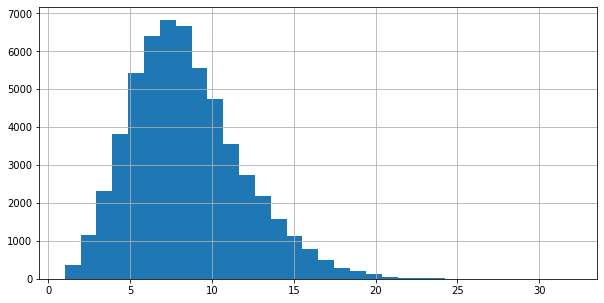

In [68]:
# Add #of_ingred column 
recipes['#of_ingred'] = 32-recipes.isnull().sum(axis=1)
# Plot distribution
recipes['#of_ingred'].hist(bins=32, figsize=(10,5));

In [69]:
round(recipes['#of_ingred'].mean(), 2)

8.22

As mentioned before our recipes have a range from 1 to 32 ingredients each.  The distribution of the number of ingredients in all the recipes is slightly right skewed.  Generally most recipes have anywhere from 2 to 15 ingredients and an overall average of 8.22 ingredients per recipe. 

### Average Number of Ingredients by Cuisine

In [70]:
num_ing = recipes.groupby('Cuisine').mean().sort_values(by=['#of_ingred'], ascending=False).reset_index().iloc[:,[0,1]]
num_ing

Cuisine  #of_ingred
0     SoutheastAsian   11.317287
1            African   10.451705
2         SouthAsian   10.286634
3      LatinAmerican    9.379499
4          EastAsian    8.956210
5   SouthernEuropean    8.860766
6      MiddleEastern    8.389147
7    EasternEuropean    8.388451
8    WesternEuropean    8.025950
9      NorthAmerican    7.962094
10  NorthernEuropean    6.824000

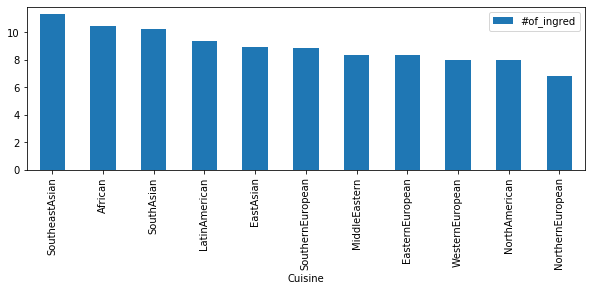

In [71]:
num_ing.plot.bar(x='Cuisine', figsize=(10,3));

Southeast Asian recipes have the most ingredients per recipe on average at 11.32 ingredients.  African and South Asian recipes also have more than 10 ingredients on averag.  Northern European recipes have the fewest average number of ingredients at 6.82, a little more than half the average of Southeast Asian recipes and North American recipes have the second smallest number of ingredients on average at 7.96.

### Distribution of the Number of Ingredients by Cuisine

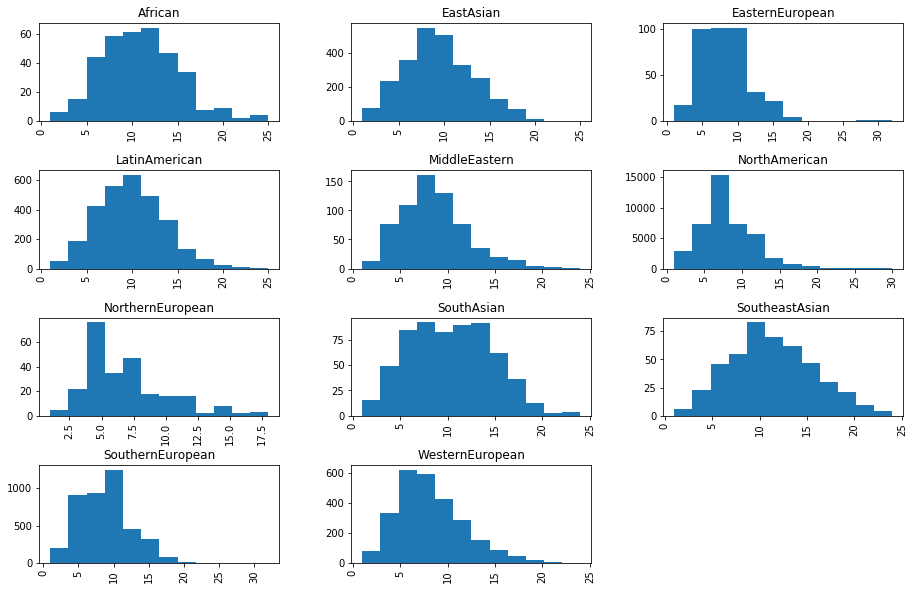

In [72]:
recipes['#of_ingred'].hist(by=recipes['Cuisine'], bins=12, figsize=(15,10));

We can visually see the differences in the distributions of ingredients per cuisine above. The peak of the distribution for all European cuisines as well as North American cusine clearly falls under 10 ingredients, while the peak for Southeast Asian, African, South Asian, and Latin American	cuisines clearly falls at about 10 ingredients.  Although we can see the range for Eastern European, Southern European, and Northern Euopean cuisines extends to 30 while the rest are 25 or less.  

### Most Common Ingredients Overall

In [73]:
# Add recipeID (recipe#) column 
recipes['recipe#'] = recipes.index+1

In [95]:
ingredient_list = pd.melt(recipes, id_vars=['Cuisine','recipe#'], value_vars=columns[1:]).dropna()
ingredient_list.rename(columns={"variable":"ingred#", "value":"ingredient"}, inplace=True)
#ingredient_list.head()
#ingredient_list.tail()
len(ingredient_list)

464407

In [75]:
ingredient_counts = pd.DataFrame(ingredient_list.ingredient.value_counts())
ingredient_counts.shape
ingredient_counts.head(10)

(381, 1)

ingredient
egg                 20951
wheat               20782
butter              20744
onion               18031
garlic              16893
milk                12895
vegetable_oil       10759
cream               10152
tomato               9909
olive_oil            9844

There are 464,407 total ingredients included in all 56,498 recipes and 381 unique ingredients.  Eggs are the most popular ingredient, followed by wheat, butter, onion and garlic. 

In [78]:
ingredient_counts.tail(17)

ingredient
strawberry_juice           2
angelica                   1
lilac_flower_oil           1
strawberry_jam             1
pelargonium                1
geranium                   1
muscat_grape               1
roasted_pecan              1
emmental_cheese            1
roasted_hazelnut           1
mate                       1
beech                      1
jasmine_tea                1
roasted_nut                1
jamaican_rum               1
durian                     1
sturgeon_caviar            1

There are 16 ingredients that only show up once in all recipes: mate, jamaican rum, geranium, roasted nut, beech, jasmine tea, muscat grape, angelica, durian, strawberry jam, sturgeon caviar, roasted pecan, pelargonium, lilac flower oil, roasted hazelnut, and emmental cheese. Although it is not surprising given the somewhat exoxtic ingredients in the list.

#### Text Anaylsis

In [80]:
len(corpus.words())
len(corpus.sents())

464405

56498

In [173]:
ingredients_sorted = sorted(list(corpus.words()))
len(set(ingredients_sorted))

381

Our corpus lengths agree (close enough) with the numbers we got using Pandas: 464,405 total ingredients included in 56,498 recipes with 381 unique ingredients.  Not sure why we are off by just two ingredients, but the difference is so small that it should not affect our analysis.  

In [174]:
fdist = nltk.FreqDist(corpus.words())

In [175]:
def top_half(ingredients, fdist):
    tw=len(ingredients)
    tcount=0
    wcount=0
    for word, count in fdist.most_common():
        tcount=tcount+count
        wcount=wcount+1
        if tcount>(tw/2):
            return(wcount)
            break
top_half(ingredients_sorted, fdist)

22

The following **22 ingredients represent half of the total ingredients** in the recipes.

In [155]:
pd.DataFrame(fdist.most_common()[:22], columns=['ingredient', 'count'])

ingredient  count
0             egg  20950
1           wheat  20782
2          butter  20744
3           onion  18031
4          garlic  16893
5            milk  12895
6   vegetable_oil  10759
7           cream  10152
8          tomato   9909
9       olive_oil   9844
10   black_pepper   9752
11         pepper   9060
12        vanilla   9025
13        cayenne   7950
14        vinegar   7695
15  cane_molasses   7655
16    bell_pepper   5847
17       cinnamon   5603
18        parsley   5562
19        chicken   5294
20    lemon_juice   5033
21           beef   4822

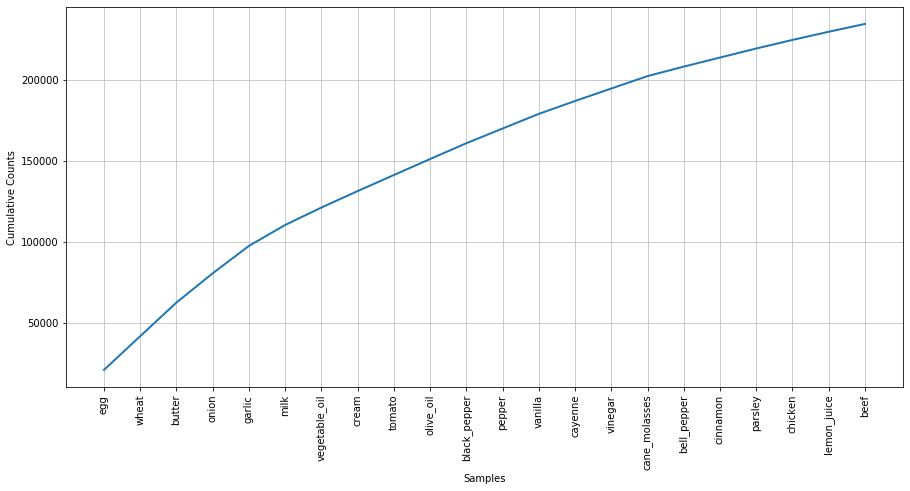

In [103]:
plt.figure(figsize=(15,7))
fdist.plot(22, cumulative = True);

**The top 50 ingredients each show up 2500 times or more.**

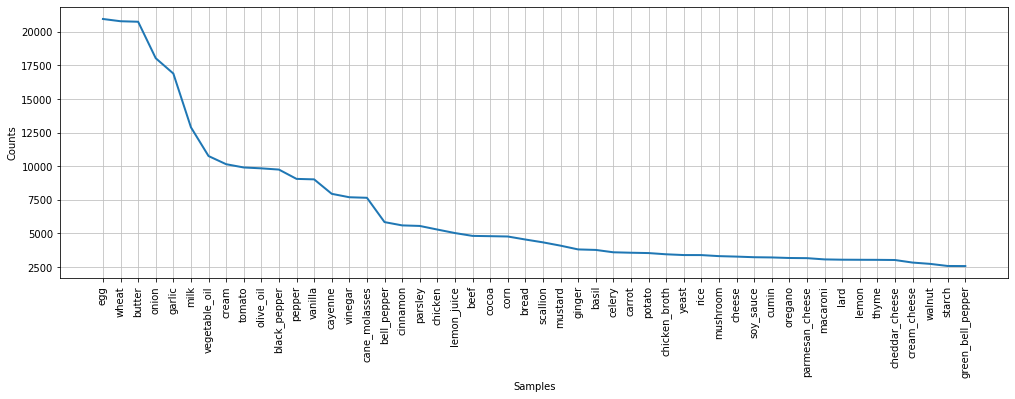

In [102]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

In [101]:
2500/56498

0.04424935395943219

### Most Common Ingredients by Cuisine

In [105]:
cuisine_counts = pd.DataFrame(ingredient_list.groupby('Cuisine').ingredient.value_counts())
cuisine_counts.columns = ["count"]

In [106]:
cuisine_counts.groupby('Cuisine').head(1)

count
Cuisine          ingredient       
African          olive_oil     196
EastAsian        soy_sauce    1358
EasternEuropean  butter        201
LatinAmerican    cayenne      1946
MiddleEastern    wheat         272
NorthAmerican    butter      17088
NorthernEuropean butter        160
SouthAsian       cumin         375
SoutheastAsian   garlic        284
SouthernEuropean olive_oil    2612
WesternEuropean  butter       1395

The top ingredient varies by cuisine however, surprisingly the top ingredient overall, eggs, does not take the top slot for any one of the cuisines separately.  This may indicate that eggs are cross-culturally relevant as an ingredient while other comon ingredieents may be more culturally specific.  Butter, the third most popular ingredient overall takes the top spot for 4 cuisines in our list: Eastern European, North American, Northern European, and Western European.

### Top 5 Most Common Ingredients by Cuisine

In [359]:
cuisine_counts.groupby('Cuisine').head(5)

count
Cuisine          ingredient          
African          olive_oil        196
                 onion            189
                 cumin            166
                 garlic           160
                 cayenne          116
EastAsian        soy_sauce       1358
                 garlic          1302
                 scallion        1188
                 cayenne         1008
                 sesame_oil       937
EasternEuropean  butter           201
                 egg              197
                 wheat            197
                 onion            162
                 cream            111
LatinAmerican    cayenne         1946
                 onion           1906
                 garlic          1752
                 tomato          1579
                 corn             868
MiddleEastern    wheat            272
                 olive_oil        262
                 egg              239
                 onion            221
                 garlic           212
NorthAmerican    butter         17088
                 egg            16738
                 wheat          16532
                 onion          12311
                 milk           10996
NorthernEuropean butter           160
                 wheat            145
                 egg              132
                 cream             72
                 milk              56
SouthAsian       cumin            375
                 turmeric         319
                 onion            316
                 cayenne          300
                 garlic           295
SoutheastAsian   garlic           284
                 fish             226
                 cayenne          191
                 vegetable_oil    180
                 cilantro         163
SouthernEuropean olive_oil       2612
                 garlic          2181
                 tomato          1593
                 onion           1451
                 egg             1097
WesternEuropean  butter          1395
                 egg             1303
                 wheat           1278
                 onion            720
                 milk             693

The same 4 cuisines Eastern European, North American, Northern European, and Western European, all share the same top 5 ingredients: butter, eggs, wheat, milk/cream and onion.  Onion, garlic and olive oil show up regularly in the other cuisines top 5 lists, which is not surprising considering they show in slots 4, 5 and 10 respectively overall.  Not surprisingly, eggs show up in 6 out of the 11 cuisines.

### Top ingredients as percent of the total number of recipes by cuisine

In [108]:
cuisine_props = pd.DataFrame(ingredient_list.groupby('Cuisine').ingredient.value_counts(normalize=True)*100)
cuisine_props.columns = ["percent"]

In [109]:
cuisine_props.reset_index().groupby('Cuisine').head(1).sort_values(by=['percent'], ascending=False)

Cuisine ingredient   percent
1478  NorthernEuropean     butter  9.378664
637      LatinAmerican    cayenne  7.112573
2042  SouthernEuropean  olive_oil  7.052217
2332   WesternEuropean     butter  6.536713
439    EasternEuropean     butter  6.289111
197          EastAsian  soy_sauce  6.036092
1653        SouthAsian      cumin  5.870382
1858    SoutheastAsian     garlic  5.491106
0              African  olive_oil  5.327535
1124     NorthAmerican     butter  5.168503
897      MiddleEastern      wheat  5.026797

The top ingredient in each cuisine shows up in a range from 5% to just over 7% of all recipes for each cuisine except for Northern European cuisine whose top ingredient, butter, shows up in over 9% of recipes!

In [110]:
cuisine_props.sort_values(by=['percent'], ascending=False).head(20)

percent
Cuisine          ingredient          
NorthernEuropean butter      9.378664
                 wheat       8.499414
                 egg         7.737397
LatinAmerican    cayenne     7.112573
SouthernEuropean olive_oil   7.052217
LatinAmerican    onion       6.966374
WesternEuropean  butter      6.536713
LatinAmerican    garlic      6.403509
EasternEuropean  butter      6.289111
                 wheat       6.163955
                 egg         6.163955
WesternEuropean  egg         6.105618
EastAsian        soy_sauce   6.036092
WesternEuropean  wheat       5.988473
SouthernEuropean garlic      5.888547
SouthAsian       cumin       5.870382
EastAsian        garlic      5.787181
LatinAmerican    tomato      5.771199
SoutheastAsian   garlic      5.491106
African          olive_oil   5.327535

Looking at the top 20 ingredients as percentages of their respective cuisines shows a slightly different picture.  No Northern American ingredients even show up on the list because even the most common ingredient doesn't show up as frequently in Northern American cooking as some ingedients do in other cuisines, indicating that there may be more variety of ingredients between recipes in Northern American cooking.  At the other end of the spectrum Northern, Western, and Eastern European cuisines all have their top three ingredients and Latin American has its top 4 in the list indicating that there may be more commonality or less variety of ingredients between recipes in their cuisines.  

### Ingredient Pairings

In order to see which ingredients most commonly go together for each cuisine and the similarities and differences between common pairings by cuisine we first need to reshape our data into a dataframe with all the pairings across all recipes.

In [111]:
pairs = pd.DataFrame({'Cuisine':[], 'ingred1':[], 'ingred2':[]})
for i in range(1,32):
    for j in range((i+1),33):
        temp=recipes.iloc[:,[0,i,j]]
        temp.columns=['Cuisine','ingred1','ingred2']
        temp=temp.dropna()
        pairs=pairs.append(temp,ignore_index=True)

In [112]:
pairs.head()
pairs.shape

Cuisine        ingred1   ingred2
0  African        chicken  cinnamon
1  African  cane_molasses    ginger
2  African         butter    pepper
3  African      olive_oil    pepper
4  African          honey     wheat

(2036125, 3)

In [114]:
# Just double checking that there are no NA's
pairs = pairs.dropna()
pairs.shape

(2036125, 3)

There are 2,036,125 records but we reduced that number by condensing all the duplicate entries into one row and adding a column for counts.  Since we know that some cuisines are over or under reperesented we also added a column for the percentage of the total recipes for each cuisine that include that pairing.  The resulting dataframe is below.

In [115]:
pair_counts = pairs.reset_index().groupby(['Cuisine','ingred1','ingred2'], as_index=False).count()
pair_counts.rename(columns={"index":"counts"}, inplace=True)
pair_counts['total'] = pair_counts.groupby('Cuisine').counts.transform('sum')
pair_counts['percent'] = pair_counts['counts']/pair_counts['total']*100
pair_counts.head()
pair_counts.shape

Cuisine ingred1     ingred2  counts  total   percent
0  African  almond  anise_seed       1  20524  0.004872
1  African  almond     apricot       2  20524  0.009745
2  African  almond      barley       2  20524  0.009745
3  African  almond         bay       2  20524  0.009745
4  African  almond        bean       1  20524  0.004872

(123181, 6)

### Top Ingredient Pairings

In [321]:
pair_counts.sort_values(by='counts', ascending=False, inplace=True)
pair_counts.head(10)

Cuisine        ingred1  ingred2  counts    total  percent
74966  NorthAmerican          wheat      egg   10931  1395965     0.78
43137  NorthAmerican         butter    wheat   10562  1395965     0.76
42925  NorthAmerican         butter      egg    9294  1395965     0.67
75032  NorthAmerican          wheat     milk    7315  1395965     0.52
42995  NorthAmerican         butter     milk    6445  1395965     0.46
51239  NorthAmerican            egg     milk    6405  1395965     0.46
73538  NorthAmerican        vanilla      egg    5677  1395965     0.41
75160  NorthAmerican          wheat  vanilla    5645  1395965     0.40
43127  NorthAmerican         butter  vanilla    5528  1395965     0.40
73987  NorthAmerican  vegetable_oil      egg    4839  1395965     0.35

Out of all pairs **wheat and egg** came in first place when sorted by the total count. This is not surprising since North American cuisine is over represented in the dataset.  But also, looking at the top 10 pairs of ingredients, it seems **the dataset may be heavily skewed toward deserts or at least baking** recipes.  

In [322]:
pair_counts.sort_values(by='percent', ascending=False, inplace=True)
pair_counts.head(10)

Cuisine    ingred1  ingred2  counts   total  percent
76798   NorthernEuropean     butter    wheat     116    6249     1.86
76722   NorthernEuropean     butter      egg      96    6249     1.54
79059   NorthernEuropean      wheat      egg      85    6249     1.36
26676      LatinAmerican      onion  cayenne    1389  134200     1.04
18862    EasternEuropean      wheat      egg     146   14224     1.03
101651  SouthernEuropean  olive_oil   garlic    1730  172245     1.00
30036      LatinAmerican     tomato    onion    1312  134200     0.98
110061   WesternEuropean     butter    wheat     902   93223     0.97
14918    EasternEuropean     butter    wheat     136   14224     0.96
14817    EasternEuropean     butter      egg     131   14224     0.92

Sorting again by the percent of total pairs in each cuisine that the selected pair represents gives a slightly different picture.  We see **a few savory pairs** hit the top 10: **tomato and onion**, **onion and cayenne**, and **olive oil and garlic**.  

We also see that the same three pairings that were the top 3 for North America and overall, are the top 3 for Northern European cuisine as well and are present in twice as many recipes by percentage as they are in North American cuisine.

### Top 3 Pairings by Cuisine

In [618]:
pair_counts.sort_values(by=['Cuisine','percent'], ascending=[True, False]).groupby('Cuisine').head(3)

Cuisine     ingred1        ingred2  counts    total  percent
3296             African   olive_oil          cumin     120    20524     0.58
3308             African   olive_oil         garlic     106    20524     0.52
3344             African   olive_oil          onion      98    20524     0.48
6851           EastAsian     cayenne       scallion     630   107684     0.59
11868          EastAsian    scallion         garlic     620   107684     0.58
12209          EastAsian  sesame_oil      soy_sauce     585   107684     0.54
18862    EasternEuropean       wheat            egg     146    14224     1.03
14918    EasternEuropean      butter          wheat     136    14224     0.96
14817    EasternEuropean      butter            egg     131    14224     0.92
26676      LatinAmerican       onion        cayenne    1389   134200     1.04
30036      LatinAmerican      tomato          onion    1312   134200     0.98
29944      LatinAmerican      tomato        cayenne    1218   134200     0.91
37794      MiddleEastern       wheat            egg     159    24238     0.66
35340      MiddleEastern   olive_oil         garlic     145    24238     0.60
35375      MiddleEastern   olive_oil          onion     121    24238     0.50
74966      NorthAmerican       wheat            egg   10931  1395965     0.78
43137      NorthAmerican      butter          wheat   10562  1395965     0.76
42925      NorthAmerican      butter            egg    9294  1395965     0.67
76798   NorthernEuropean      butter          wheat     116     6249     1.86
76722   NorthernEuropean      butter            egg      96     6249     1.54
79059   NorthernEuropean       wheat            egg      85     6249     1.36
81573         SouthAsian       cumin       turmeric     269    36060     0.75
81187         SouthAsian   coriander          cumin     246    36060     0.68
81290         SouthAsian   coriander       turmeric     246    36060     0.68
88086     SoutheastAsian      garlic  vegetable_oil     130    31513     0.41
87869     SoutheastAsian        fish         garlic     116    31513     0.37
88132     SoutheastAsian      ginger         garlic     108    31513     0.34
101651  SouthernEuropean   olive_oil         garlic    1730   172245     1.00
106338  SouthernEuropean      tomato      olive_oil    1069   172245     0.62
106292  SouthernEuropean      tomato         garlic    1044   172245     0.61
110061   WesternEuropean      butter          wheat     902    93223     0.97
122653   WesternEuropean       wheat            egg     843    93223     0.90
109895   WesternEuropean      butter            egg     813    93223     0.87

## Network and Text Analysis of Individual Cuisines

In the following sections we analyzed the top ingredient pairs for each cuisine via network graphs and the ingredients that make up half of each cuisine's total ingredients as well as the top 50 ingredients in each cuisine via text analysis.  

Ingredient pairs were filtered out by the number of occurrances to include approximately the top 80-90 pairs for each cuisine to make the visualizations easier to understand.  

### Create Functions for Text Analysis

In [228]:
def setup(category):
    fdist = nltk.FreqDist(corpus.words(categories = category))
    ingredients_sorted = sorted(list(corpus.words(categories = category)))
    return(fdist, ingredients_sorted)

In [229]:
def cuisine(category, ingredients_sorted):
    ing = len(corpus.words(categories = category))
    rec = len(corpus.sents(categories = category))
    uni_ing = len(set(ingredients_sorted))
    mkdwn = Markdown("""The **{category}** recipes in our dataset include **{ing} total ingredients** listed in 
    **{rec} recipes** with **{uni_ing} unique ingredients**.""".format(category=category, ing=ing, 
                                                                       rec=rec, uni_ing=uni_ing))
    return(mkdwn)

In [230]:
def half(category, ingredients_sorted, fdist):
    top = top_half(ingredients_sorted, fdist)
    mkdwn = Markdown("""The following **{top} ingredients represent half of the total ingredients** 
    in the **{category}** recipes.""".format(top=top, category=category))
    return(mkdwn)

## African Cuisine

In [642]:
pair_countsA=pair_counts[(pair_counts['counts']>30) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(81, 6)

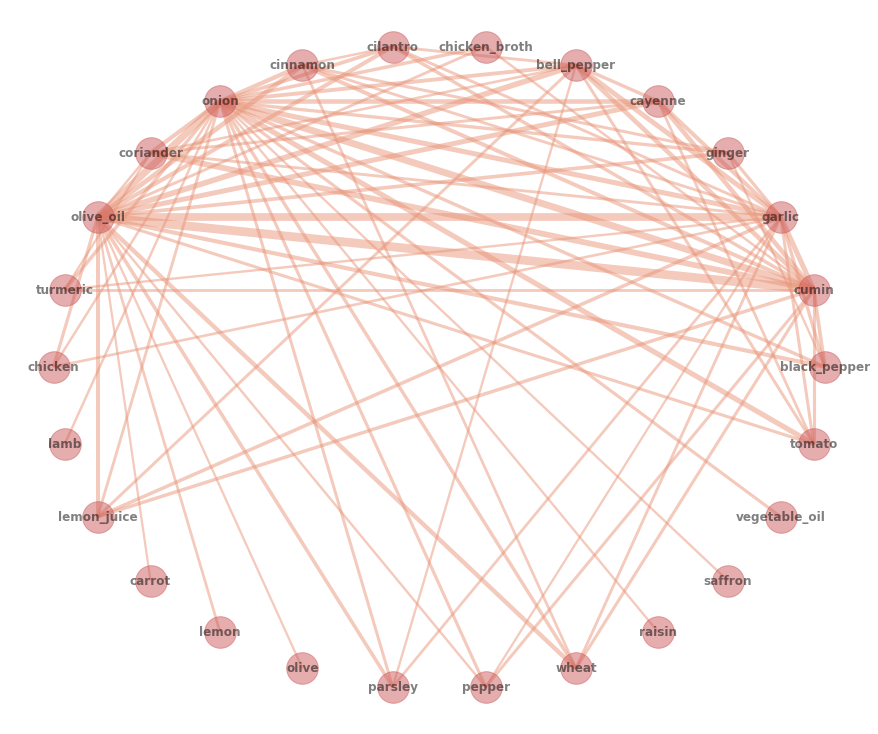

In [669]:
A=nx.from_pandas_edgelist(pair_countsA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in A.edges(data=True)]
nx.draw_circular(A, with_labels=True, node_color="indianred", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="darksalmon", alpha=0.5)

The centrality of **spices** to African cooking really stands out in the graph above which includes: onion, garlic, cumin, turmeric, cilantro, cayenne, ginger, parsley, cinnamon and saffron.

Chicken, lamb and chicken broth are the only animal-based foods in the graph.  

#### Text Anaylsis

In [278]:
category = "African"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **African** recipes in our dataset include **3679 total ingredients** listed in 
    **352 recipes** with **197 unique ingredients**.

In [279]:
half(category, ingredients_sorted, fdist)

The following **16 ingredients represent half of the total ingredients** 
    in the **African** recipes.

In [280]:
pd.DataFrame(fdist.most_common()[:16], columns=['ingredient', 'count'])

ingredient  count
0      olive_oil    196
1          onion    189
2          cumin    166
3         garlic    160
4        cayenne    116
5       cinnamon    114
6          wheat    114
7      coriander    104
8    bell_pepper    103
9         tomato    100
10  black_pepper     98
11        ginger     84
12   lemon_juice     81
13      cilantro     80
14       chicken     71
15       parsley     70

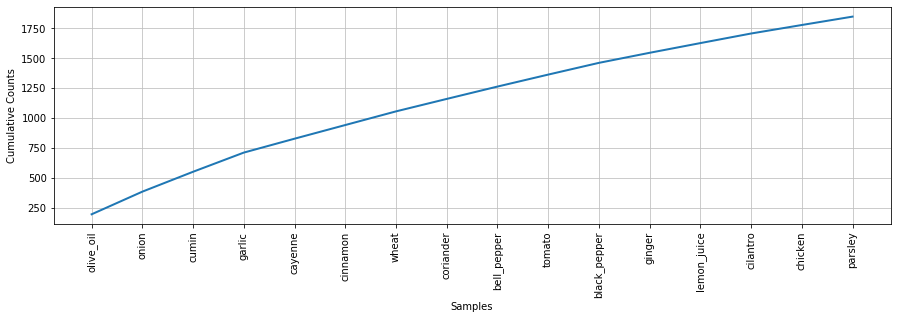

In [281]:
plt.figure(figsize=(15,4))
fdist.plot(16, cumulative = True);

#### Top 50 Ingredients in African Cuisine

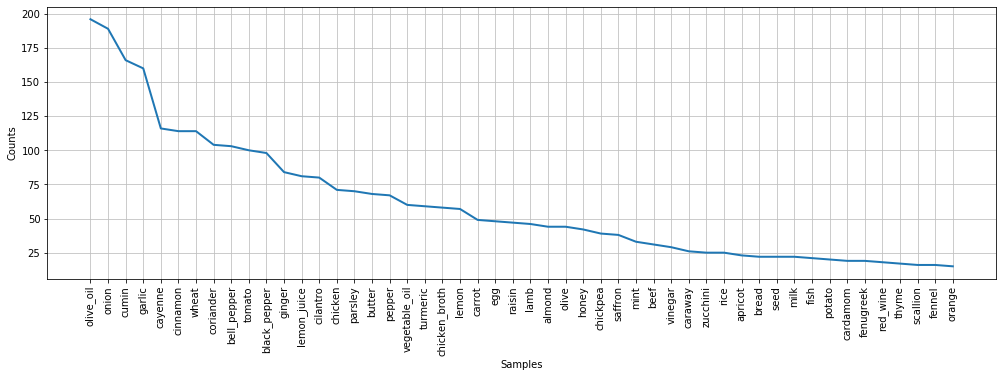

In [282]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## East Asian Cuisine

In [647]:
pair_countsEA=pair_counts[(pair_counts['counts']>200) & (pair_counts['Cuisine']=='EastAsian')]
pair_countsEA.shape

(81, 6)

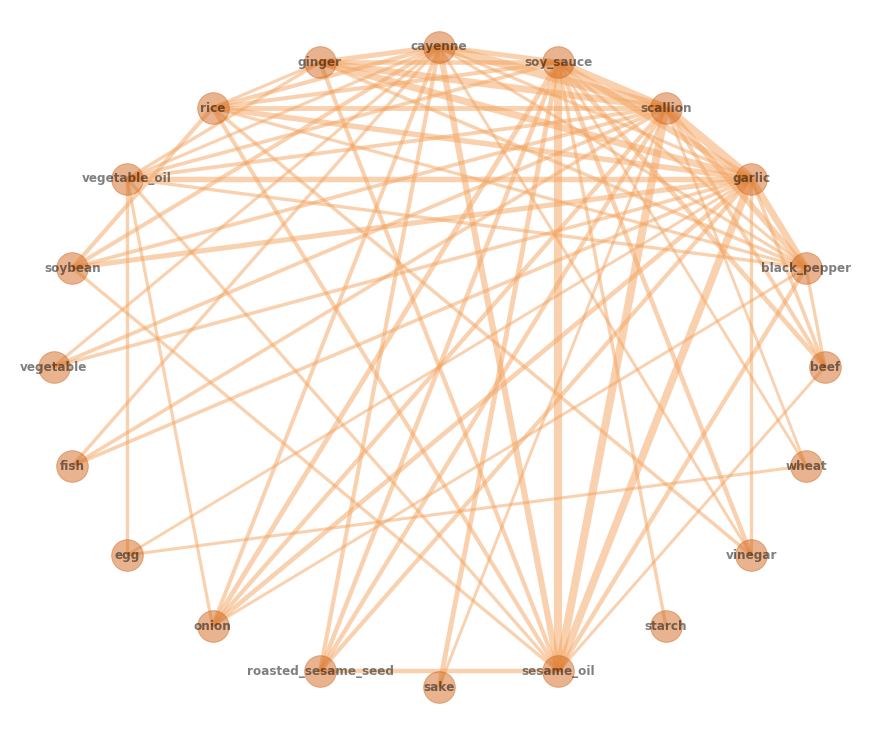

In [670]:
EA=nx.from_pandas_edgelist(pair_countsEA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in EA.edges(data=True)]
nx.draw_circular(EA, with_labels=True, node_color="chocolate", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="sandybrown", alpha=0.5)

East Asian cooking is clearly heavily influenced by **rice, cayenne, ginger, soy sauce, scallions, garlic, and sesame oil**.

Fish, eggs, and beef are the only animal-based foods in the graph.  

#### Text Anaylsis

In [285]:
category = "EastAsian"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **EastAsian** recipes in our dataset include **22498 total ingredients** listed in 
    **2512 recipes** with **242 unique ingredients**.

In [286]:
half(category, ingredients_sorted, fdist)

The following **13 ingredients represent half of the total ingredients** 
    in the **EastAsian** recipes.

In [287]:
pd.DataFrame(fdist.most_common()[:13], columns=['ingredient', 'count'])

ingredient  count
0       soy_sauce   1358
1          garlic   1302
2        scallion   1188
3         cayenne   1008
4      sesame_oil    937
5            rice    849
6          ginger    818
7    black_pepper    761
8   vegetable_oil    760
9         soybean    627
10          onion    590
11            egg    567
12        vinegar    543

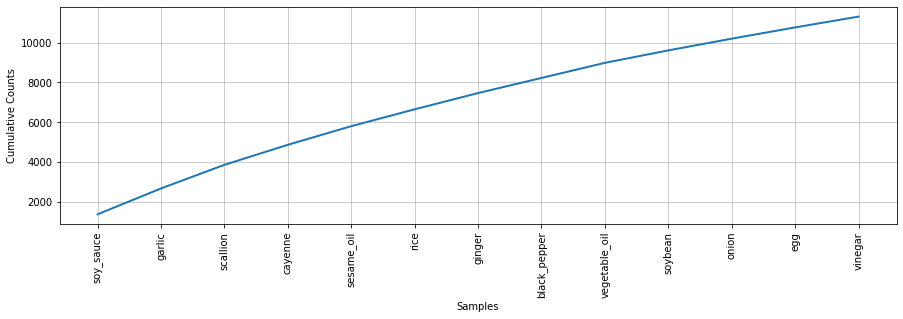

In [288]:
plt.figure(figsize=(15,4))
fdist.plot(13, cumulative = True);

#### Top 50 Ingredients in East Asian Cuisine

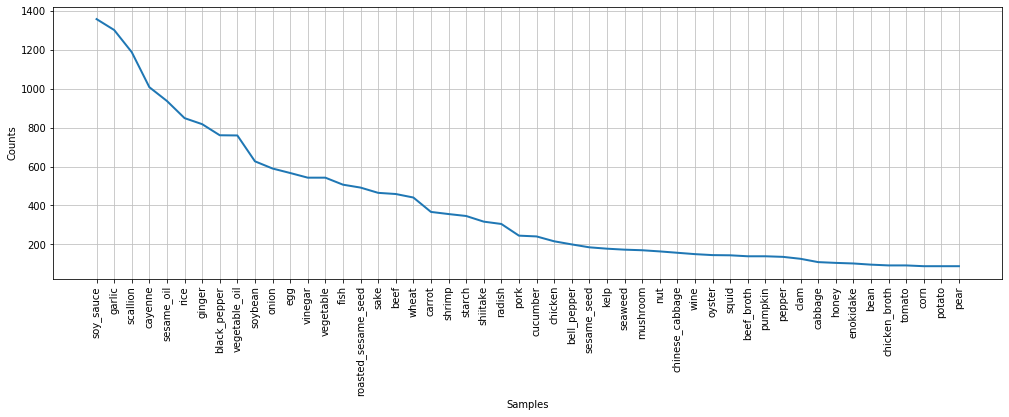

In [289]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Eastern European Cuisine

In [649]:
pair_countsEE=pair_counts[(pair_counts['counts']>18) & (pair_counts['Cuisine']=='EasternEuropean')]
pair_countsEE.shape

(85, 6)

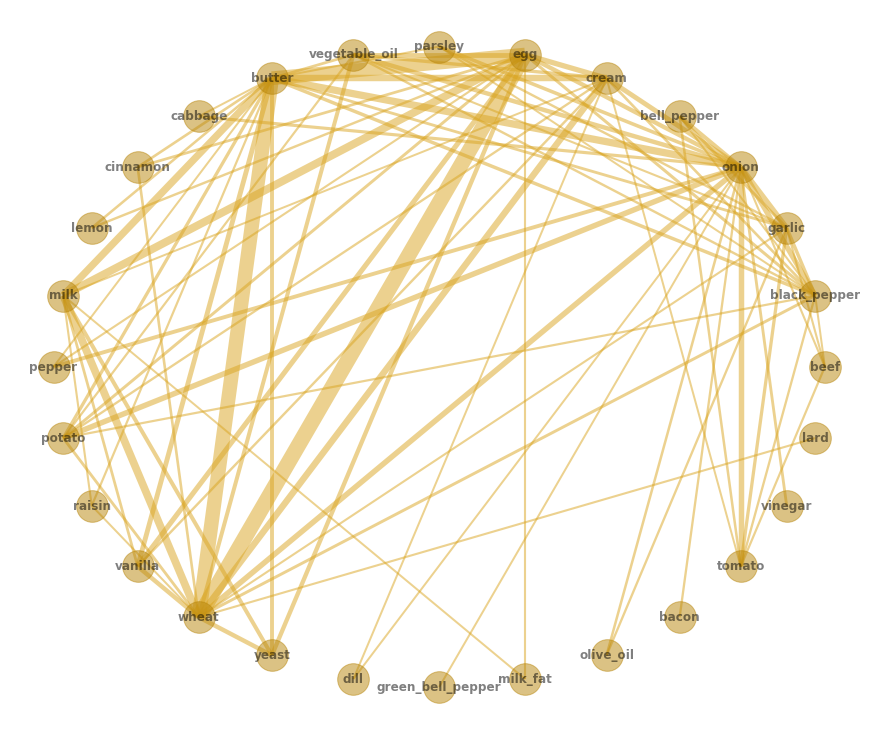

In [671]:
EE=nx.from_pandas_edgelist(pair_countsEE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in EE.edges(data=True)]
nx.draw_circular(EE, with_labels=True, node_color="darkgoldenrod", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="goldenrod", alpha=0.5)

The centrality of **wheat, butter, and eggs** to Eastern European cooking is very evident in the thick triangle created by the edges between them in the graph above.  The inclusion of yeast in the graph with edges connecting it to those same three ingredients plus milk indicates a lot of baked goods, possibly **breads**.  

The animal-based foods and especially **fats** are prominent in the graph which includes: butter, eggs, milk, cream, beef, lard, bacon, and milk fat.  

#### Text Anaylsis

In [292]:
category = "EasternEuropean"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **EasternEuropean** recipes in our dataset include **3195 total ingredients** listed in 
    **381 recipes** with **198 unique ingredients**.

In [293]:
half(category, ingredients_sorted, fdist)

The following **16 ingredients represent half of the total ingredients** 
    in the **EasternEuropean** recipes.

In [294]:
pd.DataFrame(fdist.most_common()[:16], columns=['ingredient', 'count'])

ingredient  count
0          butter    201
1           wheat    197
2             egg    196
3           onion    162
4           cream    111
5            milk     94
6    black_pepper     88
7          garlic     88
8   vegetable_oil     82
9          potato     73
10         tomato     63
11        vanilla     56
12         pepper     52
13        vinegar     50
14    bell_pepper     50
15           beef     49

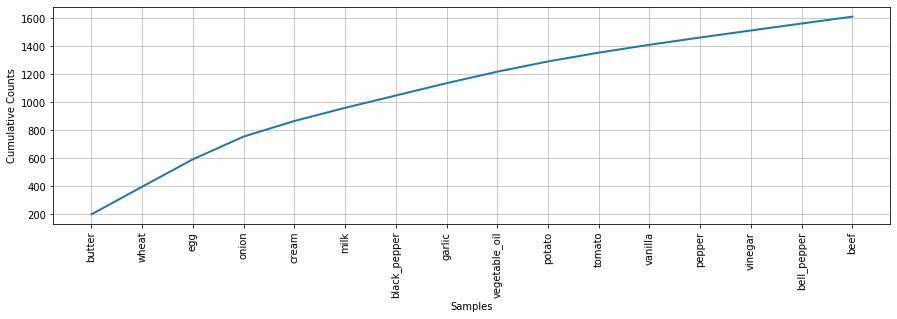

In [295]:
plt.figure(figsize=(15,4))
fdist.plot(16, cumulative = True);

#### Top 50 Ingredients in Eastern European  Cuisine

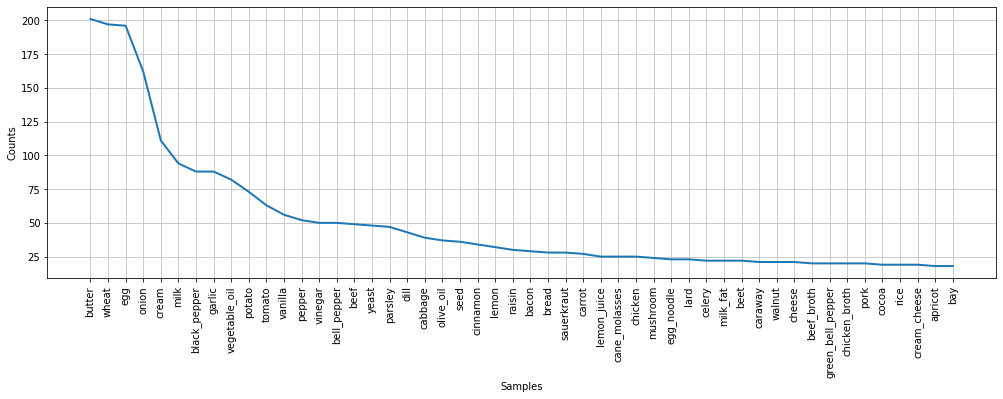

In [296]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Latin American Cuisine

In [654]:
pair_countsLA=pair_counts[(pair_counts['counts']>220) & (pair_counts['Cuisine']=='LatinAmerican')]
pair_countsLA.shape

(86, 6)

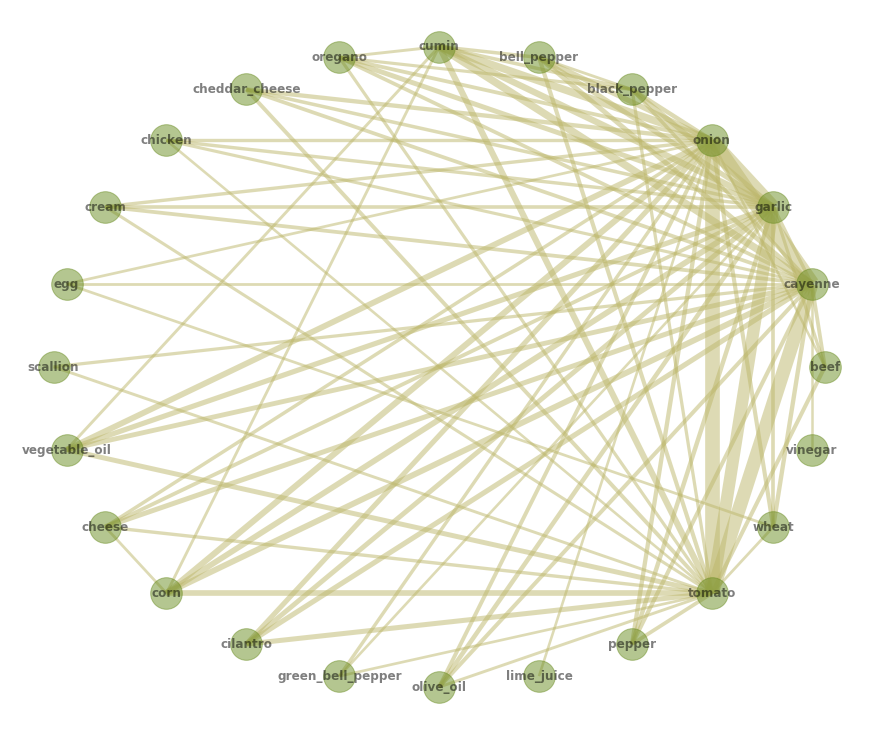

In [672]:
LA=nx.from_pandas_edgelist(pair_countsLA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in LA.edges(data=True)]
nx.draw_circular(LA, with_labels=True, node_color="olivedrab", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="darkkhaki", alpha=0.5)

**Onion, garlic, cayenne and tomatoes** are central to Latin American cooking and stand out in the graph above with thick edges connecting all of them to each other.  Although **corn** is there it's surprisinng to me that it isn't more prominent but this may be due to the lumping together of all Latin American cuisines into one broad category.

Animal-based foods are more prominent Latin American cuisine and especially **cheeses** with the inclusion of beef, cheese, eggs, cream, chicken, and cheddar cheese.  

#### Text Anaylsis

In [299]:
category = "LatinAmerican"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **LatinAmerican** recipes in our dataset include **27360 total ingredients** listed in 
    **2917 recipes** with **260 unique ingredients**.

In [300]:
half(category, ingredients_sorted, fdist)

The following **14 ingredients represent half of the total ingredients** 
    in the **LatinAmerican** recipes.

In [301]:
pd.DataFrame(fdist.most_common()[:14], columns=['ingredient', 'count'])

ingredient  count
0         cayenne   1946
1           onion   1906
2          garlic   1752
3          tomato   1579
4            corn    868
5           cumin    833
6   vegetable_oil    732
7        cilantro    724
8           wheat    660
9          pepper    640
10    bell_pepper    604
11   black_pepper    576
12      olive_oil    556
13         cheese    543

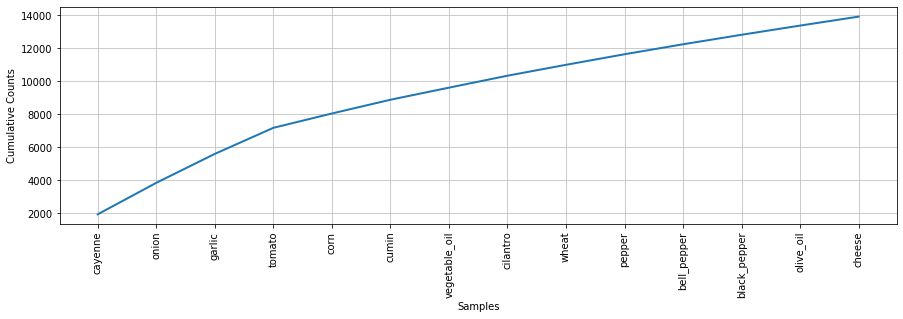

In [302]:
plt.figure(figsize=(15,4))
fdist.plot(14, cumulative = True);

#### Top 50 Ingredients in Latin American Cuisine

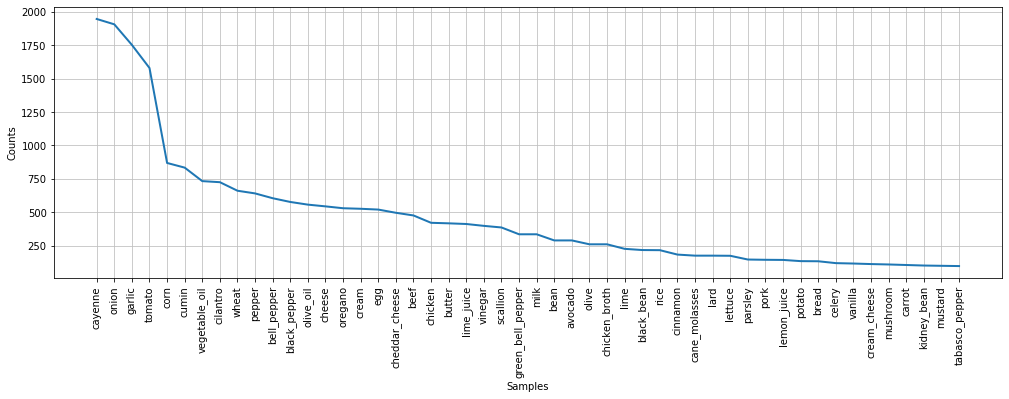

In [303]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Middle Eastern Cuisine

In [658]:
pair_countsME=pair_counts[(pair_counts['counts']>29) & (pair_counts['Cuisine']=='MiddleEastern')]
pair_countsME.shape

(84, 6)

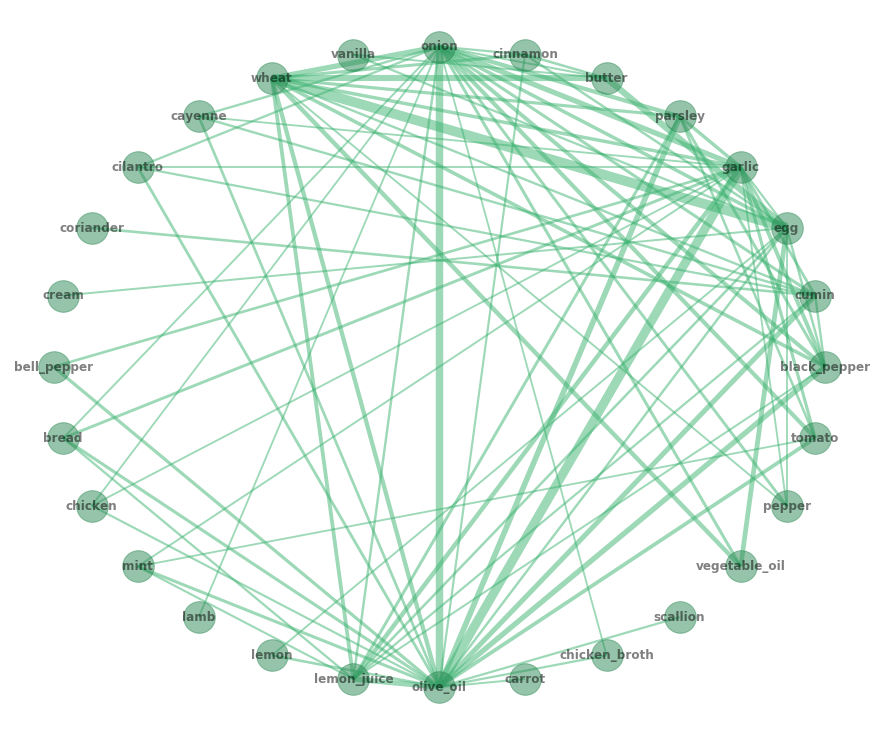

In [673]:
ME=nx.from_pandas_edgelist(pair_countsME, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in ME.edges(data=True)]
nx.draw_circular(ME, with_labels=True, node_color="seagreen", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="mediumseagreen", alpha=0.5)

**Olive oil, lemon juice, wheat, onion, garlic and eggs** look like the most heavily connected foods in Mediterranean cuisine.

Chicken, lamb, chicken broth, eggs, butter and cream are the only animal-based foods in the graph.  

#### Text Anaylsis

In [306]:
category = "MiddleEastern"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **MiddleEastern** recipes in our dataset include **5411 total ingredients** listed in 
    **645 recipes** with **227 unique ingredients**.

In [307]:
half(category, ingredients_sorted, fdist)

The following **19 ingredients represent half of the total ingredients** 
    in the **MiddleEastern** recipes.

In [308]:
pd.DataFrame(fdist.most_common()[:19], columns=['ingredient', 'count'])

ingredient  count
0           wheat    272
1       olive_oil    262
2             egg    239
3           onion    221
4          garlic    212
5          butter    165
6     lemon_juice    160
7    black_pepper    145
8         parsley    134
9   vegetable_oil    132
10       cinnamon    124
11          cumin    115
12         tomato    110
13          lemon     88
14         pepper     87
15           mint     73
16        cayenne     73
17          bread     70
18    bell_pepper     68

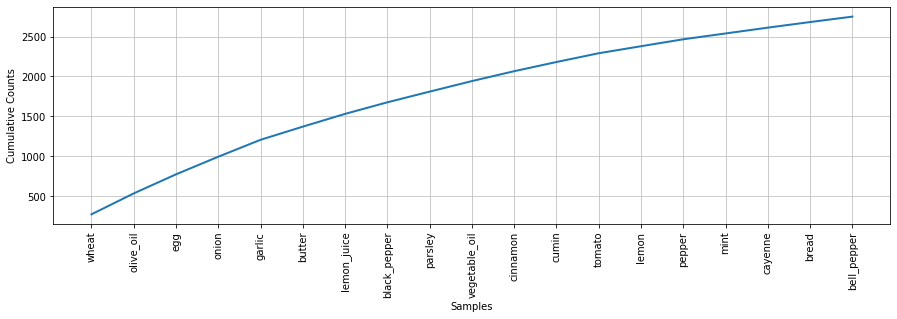

In [309]:
plt.figure(figsize=(15,4))
fdist.plot(19, cumulative = True);

#### Top 50 Ingredients in Middle Eastern Cuisine

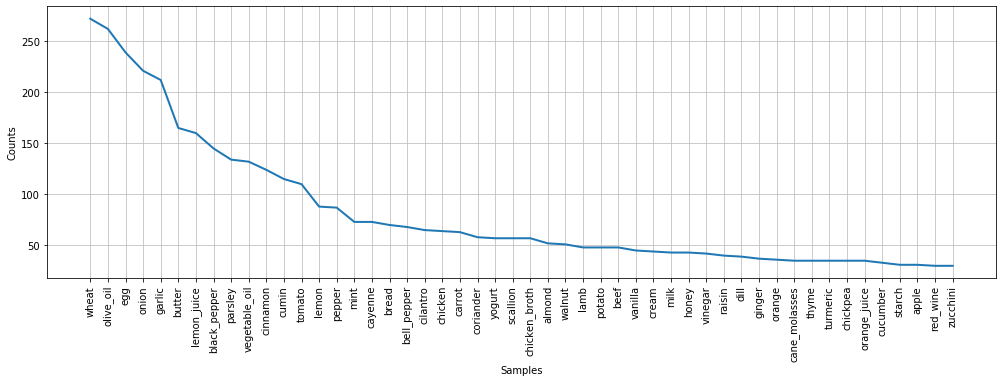

In [310]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## North American Cuisine

In [662]:
pair_countsNA=pair_counts[(pair_counts['counts']>1500) & (pair_counts['Cuisine']=='NorthAmerican')]
pair_countsNA.shape

(81, 6)

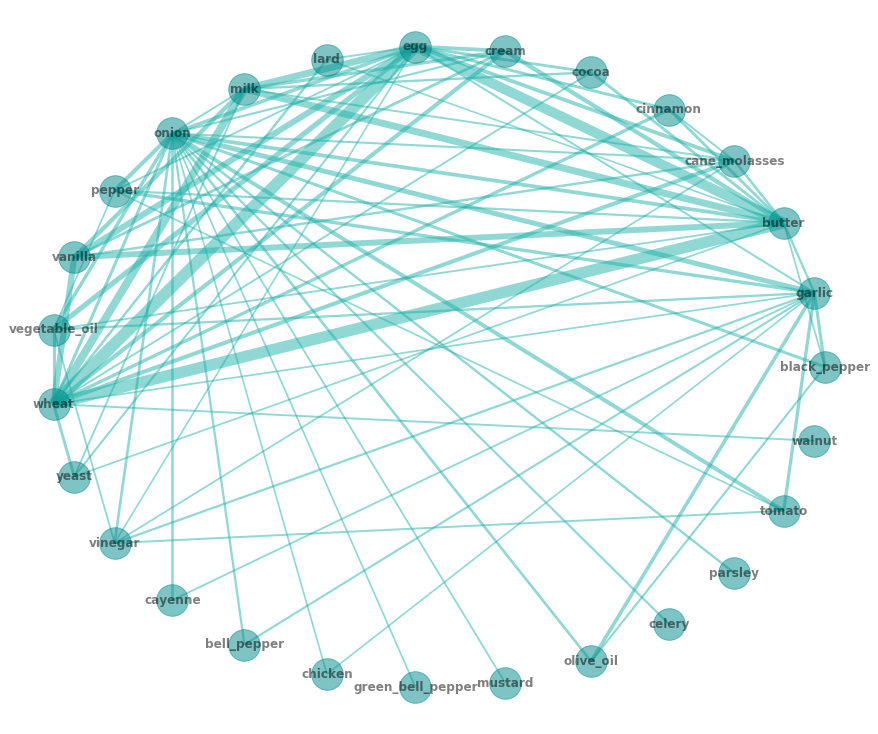

In [674]:
NA=nx.from_pandas_edgelist(pair_countsNA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in NA.edges(data=True)]
nx.draw_circular(NA, with_labels=True, node_color="darkcyan", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="lightseagreen", alpha=0.5)

Like Eastern European cooking North American cooking also has **wheat, butter, and eggs** front and center with the addtion of **milk**.  We can see two overlapping thick triangles created by the edges between them in the graph above. The inclusion of yeast here as well also indicates baked goods, possibly breads, but we also see **vanilla, cocoa, and cane molasses** which **may indicate sweets**.

Milk, lard, eggs, cream, butter, and chicken are the only animal products.  

#### Text Anaylsis

In [313]:
category = "NorthAmerican"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **NorthAmerican** recipes in our dataset include **330618 total ingredients** listed in 
    **41524 recipes** with **354 unique ingredients**.

In [314]:
half(category, ingredients_sorted, fdist)

The following **21 ingredients represent half of the total ingredients** 
    in the **NorthAmerican** recipes.

In [315]:
pd.DataFrame(fdist.most_common()[:21], columns=['ingredient', 'count'])

ingredient  count
0          butter  17088
1             egg  16738
2           wheat  16532
3           onion  12311
4            milk  10996
5          garlic  10101
6           cream   8124
7         vanilla   8081
8   vegetable_oil   7808
9          pepper   7000
10  cane_molasses   6876
11   black_pepper   6254
12         tomato   5822
13        vinegar   5666
14      olive_oil   5553
15       cinnamon   4566
16          cocoa   4338
17        cayenne   3897
18    lemon_juice   3755
19    bell_pepper   3751
20        chicken   3737

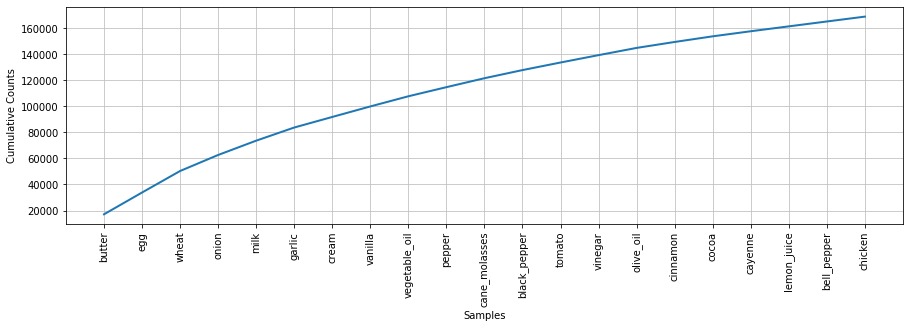

In [316]:
plt.figure(figsize=(15,4))
fdist.plot(21, cumulative = True);

#### Top 50 Ingredients in North American Cuisine

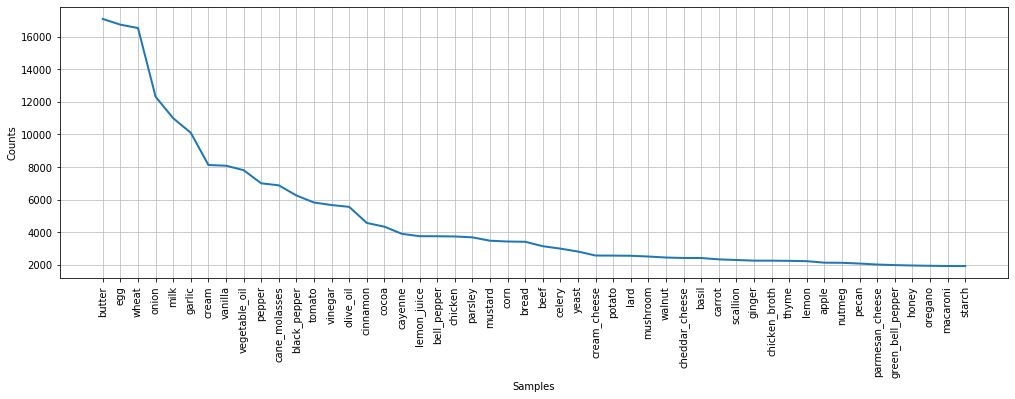

In [317]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Northern European Cuisine

In [668]:
pair_countsNE=pair_counts[(pair_counts['counts']>8) & (pair_counts['Cuisine']=='NorthernEuropean')]
pair_countsNE.shape

(91, 6)

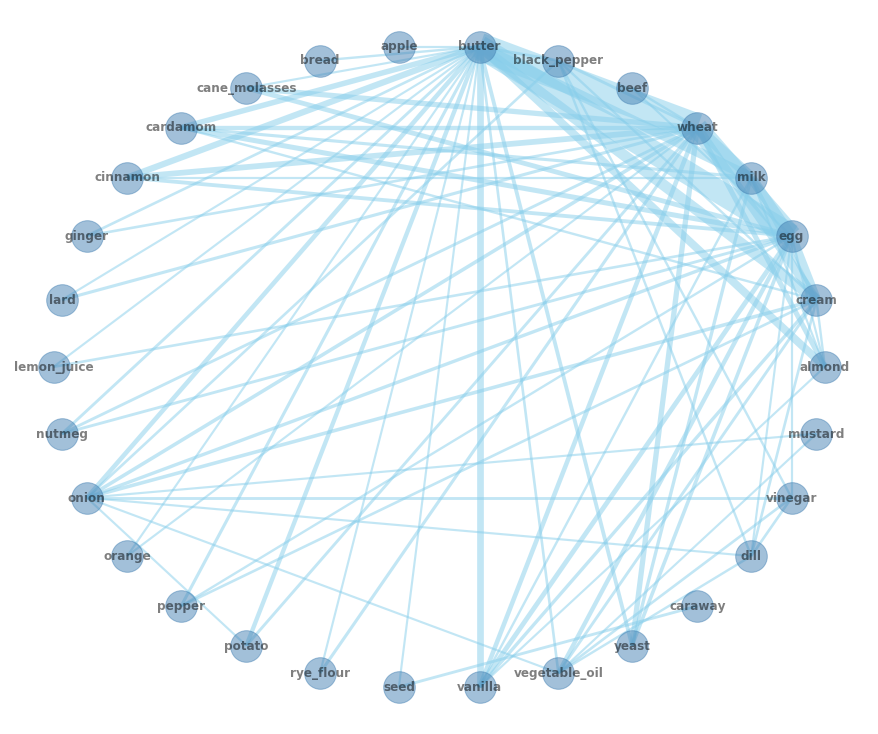

In [675]:
NE=nx.from_pandas_edgelist(pair_countsNE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in NE.edges(data=True)]
nx.draw_circular(NE, with_labels=True, node_color="steelblue", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="skyblue", alpha=0.5)

In Northern European cuisine, we see even heavier connections between **wheat, butter, and eggs** than we did in Eastern European or North American cooking.  Again we also see **yeast** here as well which may indicate baked goods like breads, but again we also see **vanilla, and cane molasses** as well as **apples and oranges** which again **may indicate sweets**.

Beef, milk, eggs, cream, butter, and lard are the only animal products.  

#### Text Anaylsis

In [320]:
category = "NorthernEuropean"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **NorthernEuropean** recipes in our dataset include **1706 total ingredients** listed in 
    **250 recipes** with **175 unique ingredients**.

In [321]:
half(category, ingredients_sorted, fdist)

The following **13 ingredients represent half of the total ingredients** 
    in the **NorthernEuropean** recipes.

In [322]:
pd.DataFrame(fdist.most_common()[:13], columns=['ingredient', 'count'])

ingredient  count
0          butter    160
1           wheat    145
2             egg    132
3           cream     72
4            milk     56
5          almond     46
6           onion     39
7         vanilla     38
8        cinnamon     38
9         vinegar     38
10  vegetable_oil     33
11   black_pepper     33
12       cardamom     33

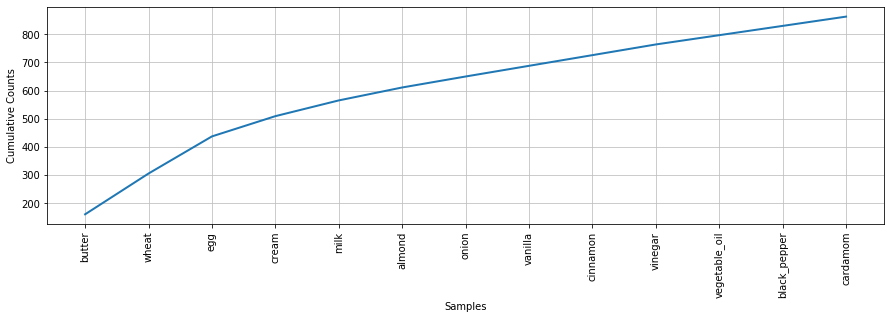

In [323]:
plt.figure(figsize=(15,4))
fdist.plot(13, cumulative = True);

#### Top 50 Ingredients in Northern European Cuisine

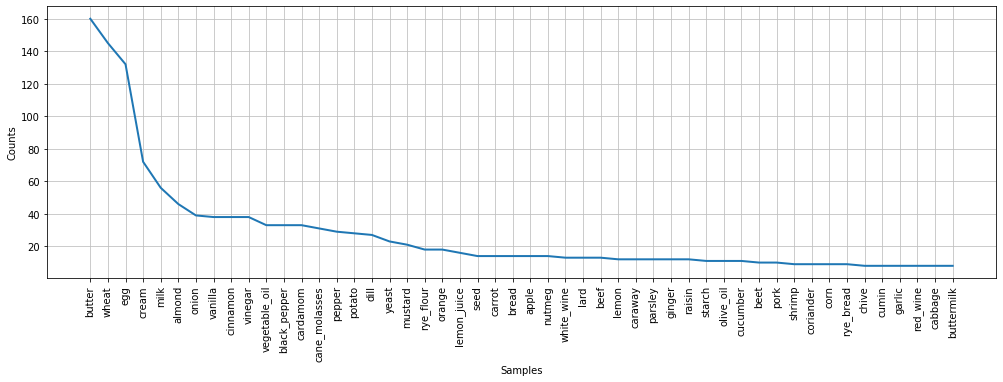

In [324]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## South Asian Cuisine

In [678]:
pair_countsSA=pair_counts[(pair_counts['counts']>62) & (pair_counts['Cuisine']=='SouthAsian')]
pair_countsSA.shape

(84, 6)

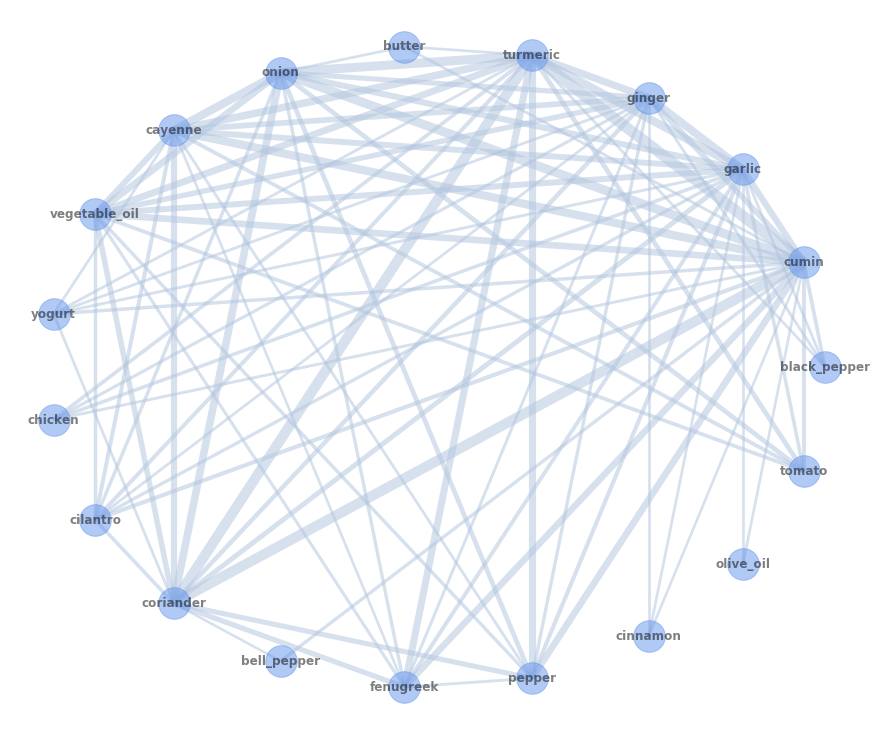

In [679]:
SA=nx.from_pandas_edgelist(pair_countsSA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SA.edges(data=True)]
nx.draw_circular(SA, with_labels=True, node_color="cornflowerblue", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="lightsteelblue", alpha=0.5)

Similar to African cooking we see **spices** are central to South Asian cuisine including: onion, garlic, cumin, turmeric, cilantro, coriander, cayenne, ginger, cinnamon, fenugreek, pepper, and black pepper.

Chicken, yogurt, and butter are the only animal-based foods in the graph.  

#### Text Anaylsis

In [327]:
category = "SouthAsian"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **SouthAsian** recipes in our dataset include **6388 total ingredients** listed in 
    **621 recipes** with **205 unique ingredients**.

In [328]:
half(category, ingredients_sorted, fdist)

The following **13 ingredients represent half of the total ingredients** 
    in the **SouthAsian** recipes.

In [329]:
pd.DataFrame(fdist.most_common()[:13], columns=['ingredient', 'count'])

ingredient  count
0           cumin    375
1        turmeric    319
2           onion    316
3         cayenne    300
4          garlic    295
5       coriander    294
6   vegetable_oil    265
7          ginger    264
8          pepper    188
9        cilantro    180
10         tomato    176
11      fenugreek    173
12         yogurt    148

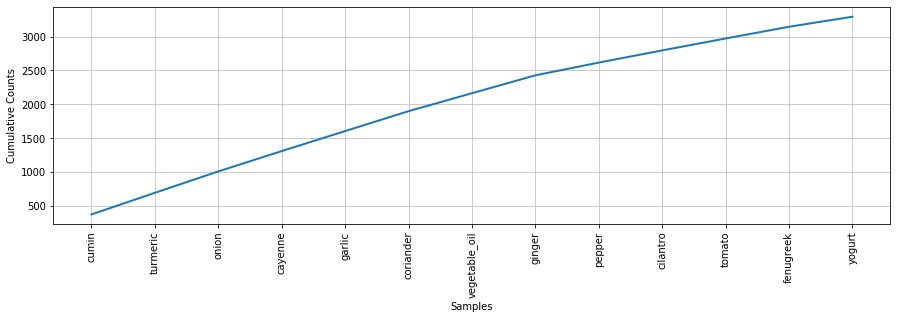

In [330]:
plt.figure(figsize=(15,4))
fdist.plot(13, cumulative = True);

#### Top 50 Ingredients in South Asian Cuisine

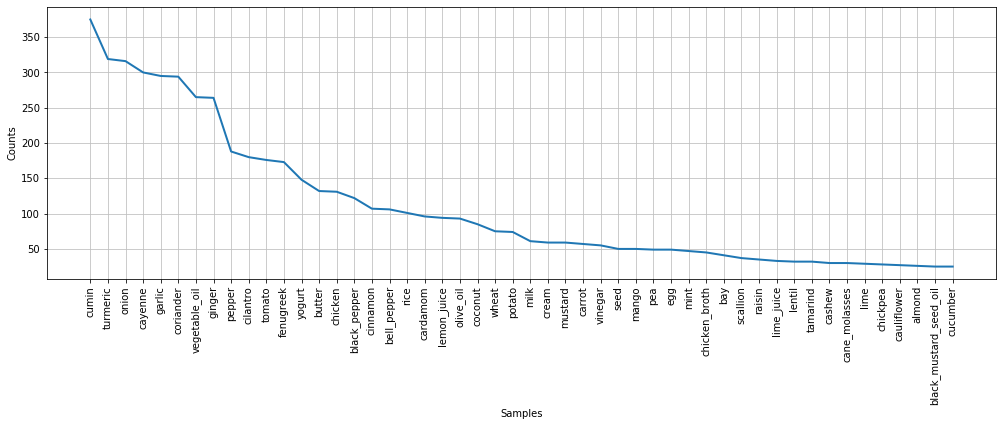

In [331]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Southeast Asian Cuisine

In [681]:
pair_countsSEA=pair_counts[(pair_counts['counts']>45) & (pair_counts['Cuisine']=='SoutheastAsian')]
pair_countsSEA.shape

(81, 6)

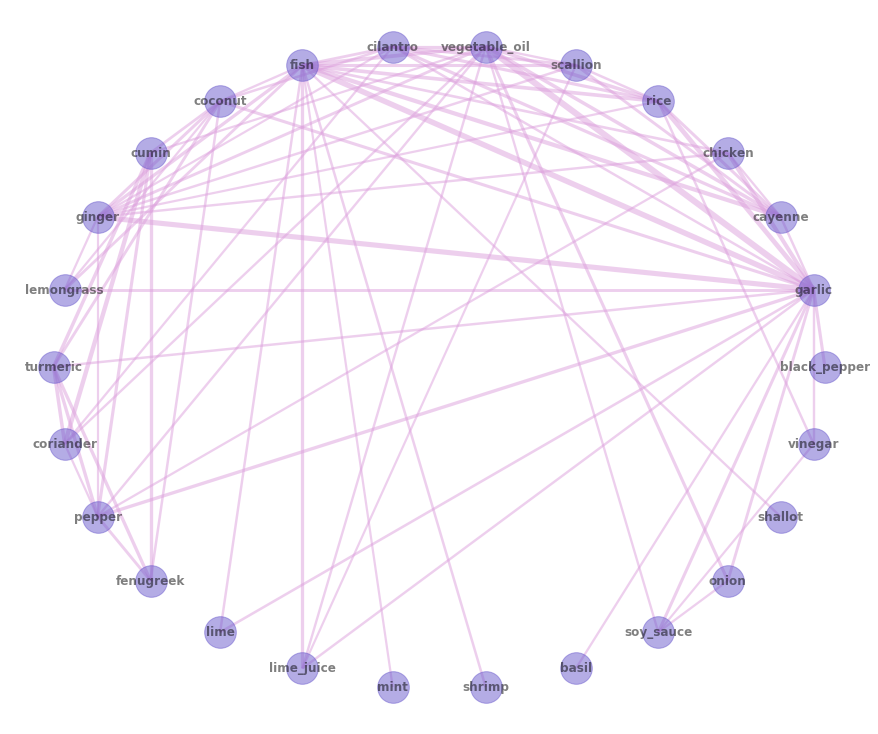

In [682]:
SEA=nx.from_pandas_edgelist(pair_countsSEA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SEA.edges(data=True)]
nx.draw_circular(SEA, with_labels=True, node_color="slateblue", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="plum", alpha=0.5)

Southeast Asian cuisine is the first we've seen that has a meat, specifically **fish**, as the most prominent ingredient in the graph.  Fish is connected to most of the other ingredients.  The only other ingredient that may have more connections is **garlic**.

Fish, shrimp, and chicken are the only animal-based ingredients in the graph.  

#### Text Anaylsis

In [334]:
category = "SoutheastAsian"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **SoutheastAsian** recipes in our dataset include **5172 total ingredients** listed in 
    **457 recipes** with **184 unique ingredients**.

In [335]:
half(category, ingredients_sorted, fdist)

The following **17 ingredients represent half of the total ingredients** 
    in the **SoutheastAsian** recipes.

In [336]:
pd.DataFrame(fdist.most_common()[:17], columns=['ingredient', 'count'])

ingredient  count
0          garlic    284
1            fish    226
2         cayenne    191
3   vegetable_oil    180
4        cilantro    163
5            rice    163
6          ginger    153
7       soy_sauce    144
8         chicken    136
9      lime_juice    132
10        coconut    129
11       scallion    128
12          onion    126
13         pepper    123
14      coriander    122
15          cumin    101
16        vinegar     98

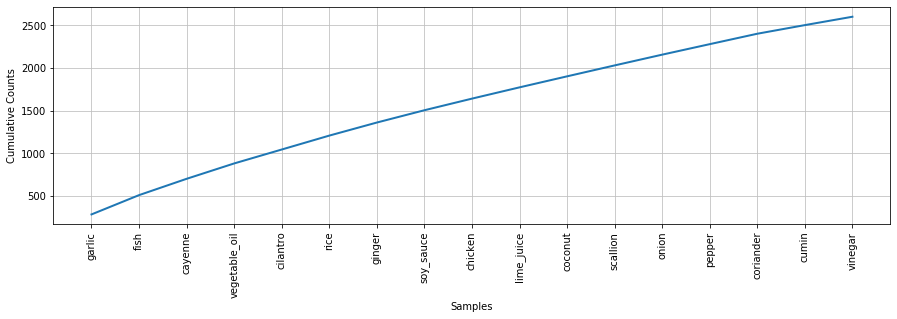

In [339]:
plt.figure(figsize=(15,4))
fdist.plot(17, cumulative = True);

#### Top 50 Ingredients in Southeast Asian Cuisine

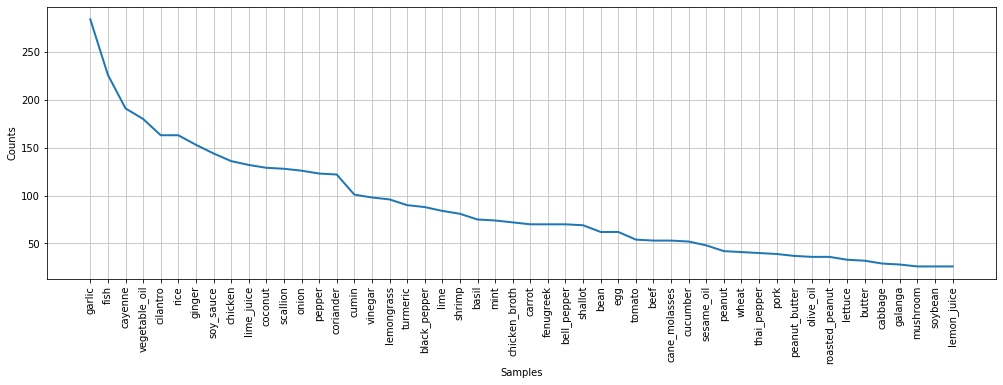

In [340]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Southern European Cuisine

In [686]:
pair_countsSE=pair_counts[(pair_counts['counts']>230) & (pair_counts['Cuisine']=='SouthernEuropean')]
pair_countsSE.shape

(83, 6)

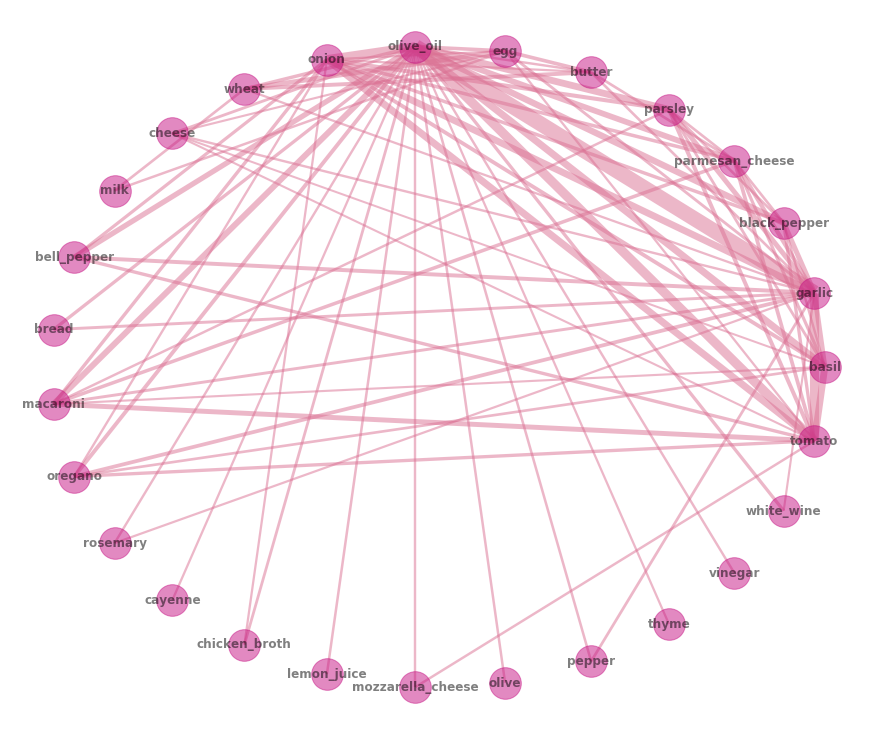

In [687]:
SE=nx.from_pandas_edgelist(pair_countsSE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SE.edges(data=True)]
nx.draw_circular(SE, with_labels=True, node_color="mediumvioletred", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="palevioletred", alpha=0.5)

In Southern European cuisine, **olive oil** seems to be in everything!  It dominates the graph creating a fanlike appearance and has a very heavy connection to **garlic and onions**, and a slightly less heavy connection to **tomatoes**.  

This is the only cuisine besides Latin American cuisine that includes **cheeses** with the inclusion of cheese, parmesan cheese, and mozzarella cheese.  Other animal products include: eggs, butter, chicken broth, and milk.

#### Text Anaylsis

In [344]:
category = "SouthernEuropean"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **SouthernEuropean** recipes in our dataset include **37037 total ingredients** listed in 
    **4180 recipes** with **290 unique ingredients**.

In [345]:
half(category, ingredients_sorted, fdist)

The following **16 ingredients represent half of the total ingredients** 
    in the **SouthernEuropean** recipes.

In [346]:
pd.DataFrame(fdist.most_common()[:16], columns=['ingredient', 'count'])

ingredient  count
0         olive_oil   2612
1            garlic   2181
2            tomato   1593
3             onion   1451
4               egg   1097
5             basil   1059
6      black_pepper   1039
7             wheat   1027
8           parsley   1025
9            butter   1020
10  parmesan_cheese   1007
11         macaroni    978
12      bell_pepper    737
13           cheese    652
14          oregano    643
15             milk    525

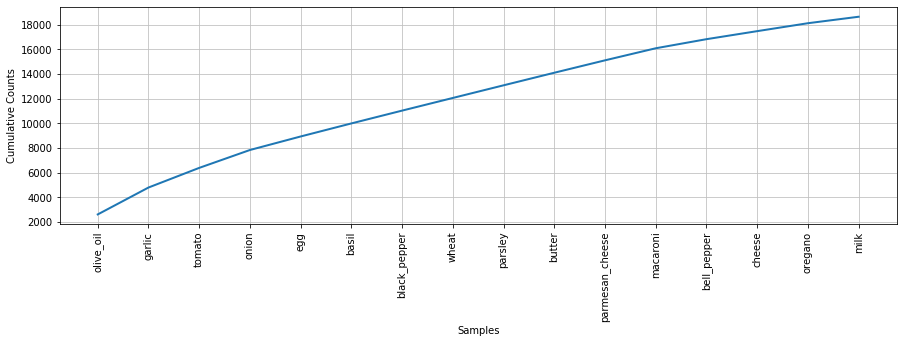

In [348]:
plt.figure(figsize=(15,4))
fdist.plot(16, cumulative = True);

#### Top 50 Ingredients in East Asian Cuisine

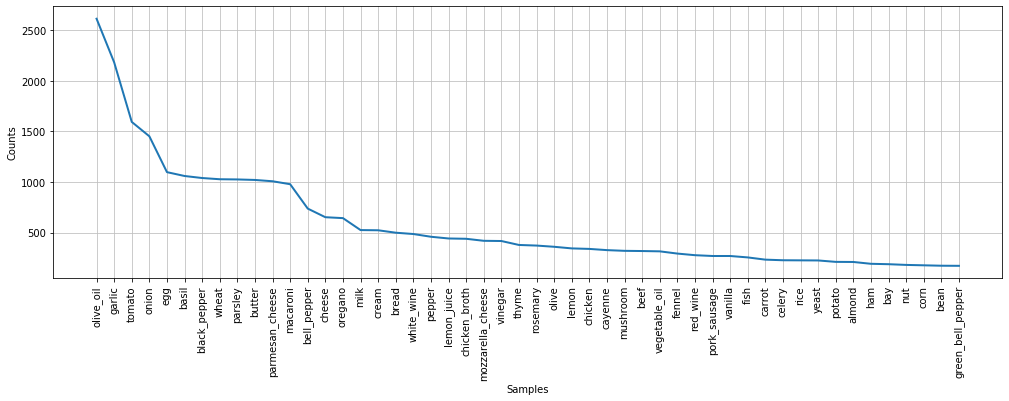

In [349]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Western European Cuisine

In [690]:
pair_countsWE=pair_counts[(pair_counts['counts']>100) & (pair_counts['Cuisine']=='WesternEuropean')]
pair_countsWE.shape

(88, 6)

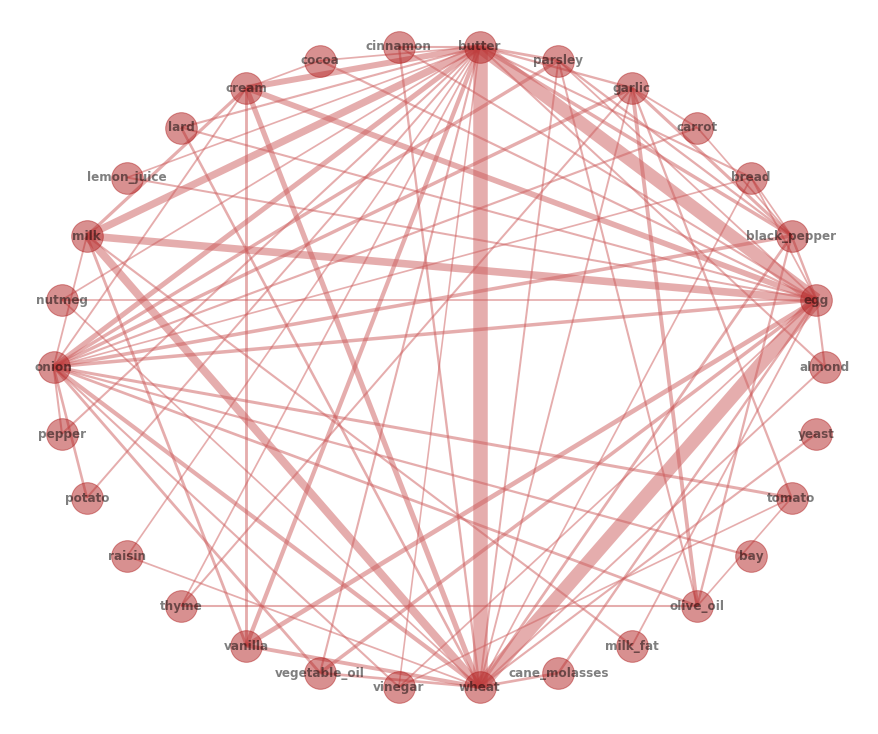

In [691]:
WE=nx.from_pandas_edgelist(pair_countsWE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in WE.edges(data=True)]
nx.draw_circular(WE, with_labels=True, node_color="firebrick", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.5)

Like Eastern European and North American cooking, Western European cuisine also has **wheat, butter, eggs and milk** front and center.  Yeast is noticably almost abasnet here however, with just one connection to wheat, so breads may still be part of the baking, but we also see **vanilla, cocoa, cinnamon, nutmeg, raisins, and cane molasses** which **may indicate that sweets are more common** in Western European cuisine than in Eastern European or North American.

Milk, eggs, cream, butter, lard, and milk fat are the only animal products.  

#### Text Anaylsis

In [352]:
category = "WesternEuropean"
fdist, ingredients_sorted = setup(category) 
cuisine(category, ingredients_sorted)

The **WesternEuropean** recipes in our dataset include **21341 total ingredients** listed in 
    **2659 recipes** with **309 unique ingredients**.

In [353]:
half(category, ingredients_sorted, fdist)

The following **19 ingredients represent half of the total ingredients** 
    in the **WesternEuropean** recipes.

In [355]:
pd.DataFrame(fdist.most_common()[:19], columns=['ingredient', 'count'])

ingredient  count
0          butter   1395
1             egg   1303
2           wheat   1278
3           onion    720
4            milk    693
5           cream    640
6    black_pepper    548
7          garlic    510
8       olive_oil    455
9   vegetable_oil    392
10        vanilla    379
11        parsley    376
12        vinegar    360
13         tomato    314
14          bread    301
15         potato    300
16         pepper    279
17          thyme    273
18         carrot    253

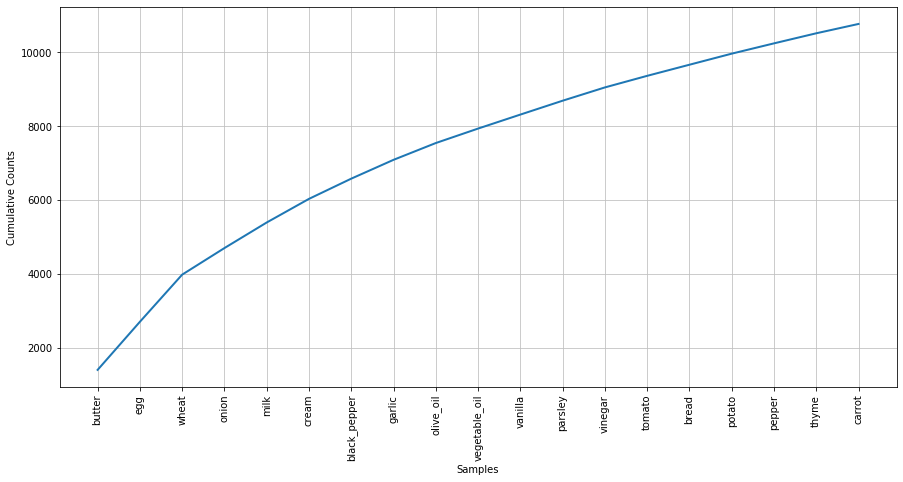

In [356]:
plt.figure(figsize=(15,7))
fdist.plot(19, cumulative = True);

#### Top 50 Ingredients in Western European Cuisine

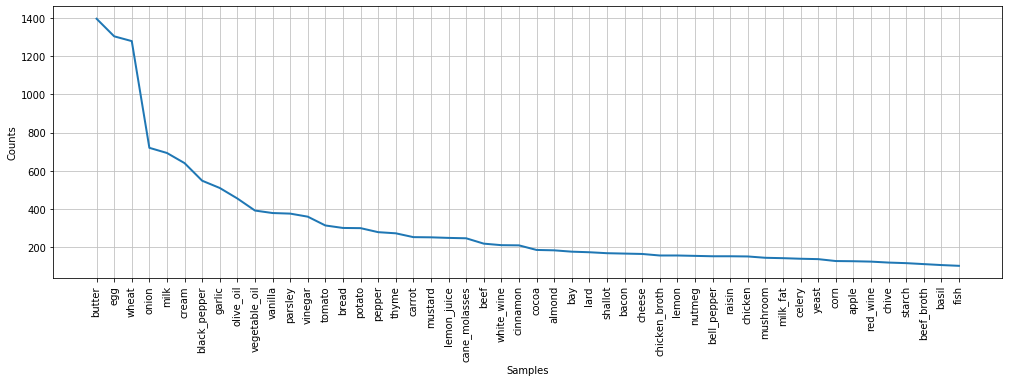

In [357]:
plt.figure(figsize=(17,5))
fdist.plot(50, );

## Bipartite Network Analysis

In order to analyze the cuisines and ingredients as a bipartite network that isn't dominated by the overabundance of Northern American recipes in our dataset we decided to take the proportional data we calculated earlier and multiply the percents by 10 to get the estimated number of recipes in 1000 that would contain each ingredient in each cuisine.  We then took the top 50 ingredients from each cuisine and created a graph object from those with cuisines and ingedients as the top and bottom nodes.  

In [482]:
network = cuisine_props.groupby('Cuisine').head(50).reset_index()
network['countPer1000recipes'] = round(network['percent']*10, 0)
network.head()

Cuisine ingredient   percent  countPer1000recipes
0  African  olive_oil  5.327535                 53.0
1  African      onion  5.137266                 51.0
2  African      cumin  4.512096                 45.0
3  African     garlic  4.349008                 43.0
4  African    cayenne  3.153031                 32.0

In [483]:
B = nx.Graph()
B.add_nodes_from(network['Cuisine'], bipartite=0)
B.add_nodes_from(network['ingredient'], bipartite=1)
B.add_weighted_edges_from([tuple(d) for d in network[['Cuisine','ingredient','countPer1000recipes']].values])

In [484]:
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 149
Number of edges: 550
Average degree:   7.3826


#### Set 'Top' and 'Bottom' Nodes

In [485]:
cuisine_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
ingredient_nodes = set(B) - cuisine_nodes

#### Density

In [488]:
print(bi.density(B, cuisine_nodes))

0.36231884057971014


## Use Island Method on the Bipartite Graph

The functions below will use the edge weights based on the number of recipes in a thousand that contain the ingredient to trim the graph into subgraphs at different minimum weight levels.  Any node not connected by at least one edge with the minimum weight will be cut from the graph.

In [490]:
def trim_edges(g, weight=1): 
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

##### Run island_method function using 8 iterations and a minimum weight 'water line' of 15...

In [556]:
islands = island_method(B, 8, 15)
print('min weight - ', '# of nodes - ', '# of island subgraphs')
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], '     -     ', len(i[1]), '     -     ', len(list(nx.connected_component_subgraphs(i[1]))))

min weight -  # of nodes -  # of island subgraphs
15      -      68      -      1
26      -      44      -      1
37      -      30      -      1
48      -      23      -      1
59      -      14      -      4
70      -      8      -      3
81      -      3      -      1
92      -      2      -      1


### Graph the Largest 'Island' Subgraph - minimum weight level 15 - 68 nodes

In [616]:
def set_colors(G):
    colors = []
    for node, data in G.nodes(data=True):
        if data['bipartite'] == 1: 
            colors.append('wheat') # Ingredients in yellow    
        else:
            colors.append('darkkhaki')  # Cuisines in Green
    return colors

In [617]:
G0=max(nx.connected_component_subgraphs(islands[0][1]), key=len)

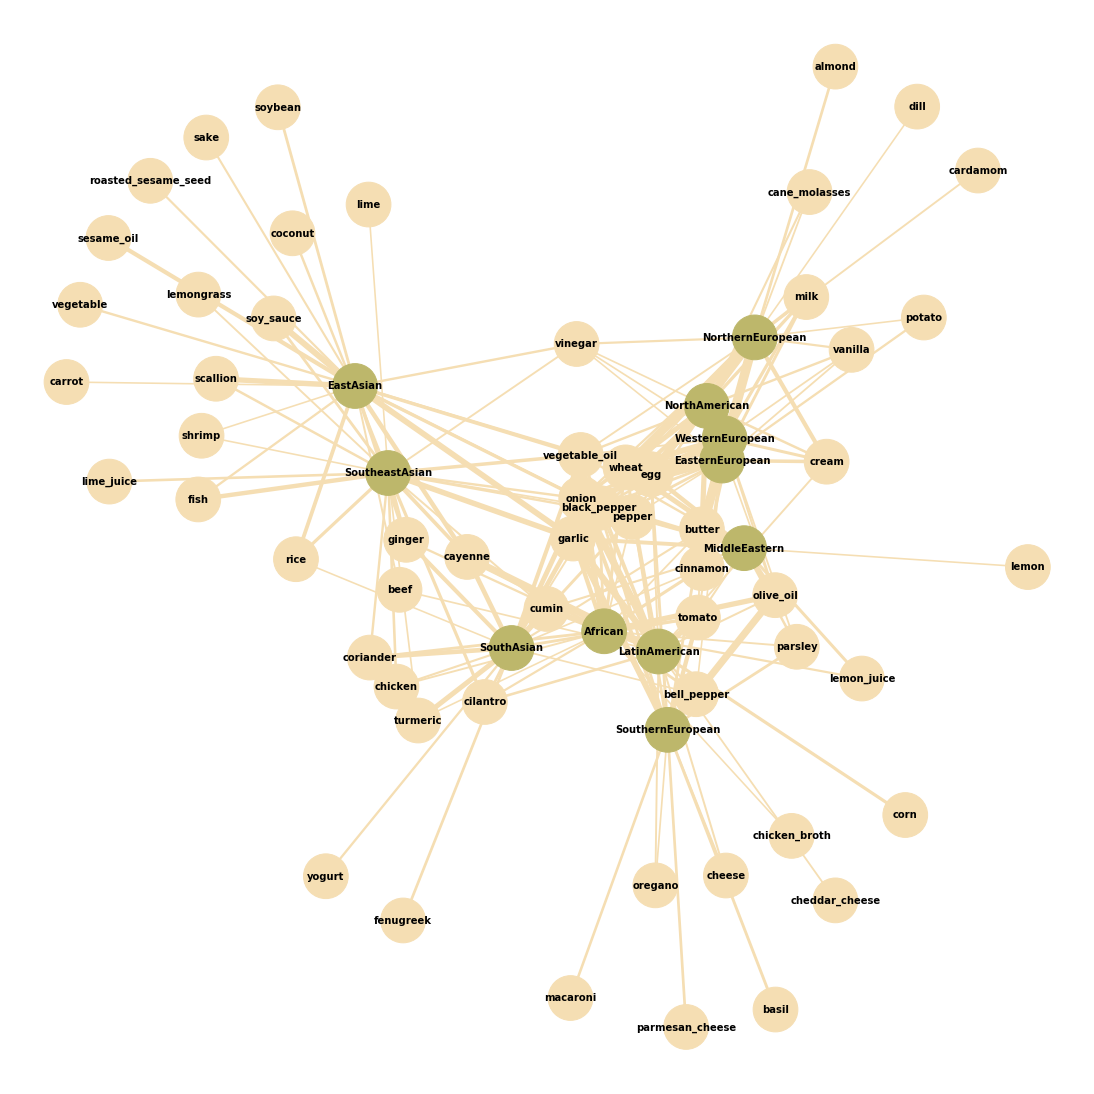

In [626]:
plt.rcParams["figure.figsize"] = (15,15) # set plot size
colors = set_colors(G0)  # set colors
weights = [edata['attr_dict'][15]/10 for f, t, edata in G0.edges(data=True)] # set weights

nx.draw(G0, with_labels=True, node_color=colors, node_size=2000, width=weights,
        font_size=10, font_weight='bold', edge_color="wheat")

In the graph above we can already see the similarities and differences among cuisines start to take shape.  East Asian while still connected tto the rest of the netowrk by a large number of ingredients asl has a number of ingedients that are unique to East Asian cuisine alone: coconut, soybeans, sake, roasted sesame seeds, sesame oil, caorrots.  The same can be said for Southeast Asian, with lime and lime juice.  Both East Asian and Southeast Asian share an affinity for shrimp, fish, scallions and soy sauce.  Ingredients unique to Southern European cooking include: Parmesan cheese, macaroni, and basil.  South Asian includes yogurt and fenugreeek which are not found in other cusines.  

We can also see the centrality of ingredients like onion, garlic, black pepper, bell peppers, tomatoes, olive oil, wheat, eggs, butter, cayenne, and cumin to a large number of cuisines.  

### Graph the Second Largest 'Island' Subgraph - minimum weight level 26 - 44 nodes

In [569]:
G1=islands[1][1]

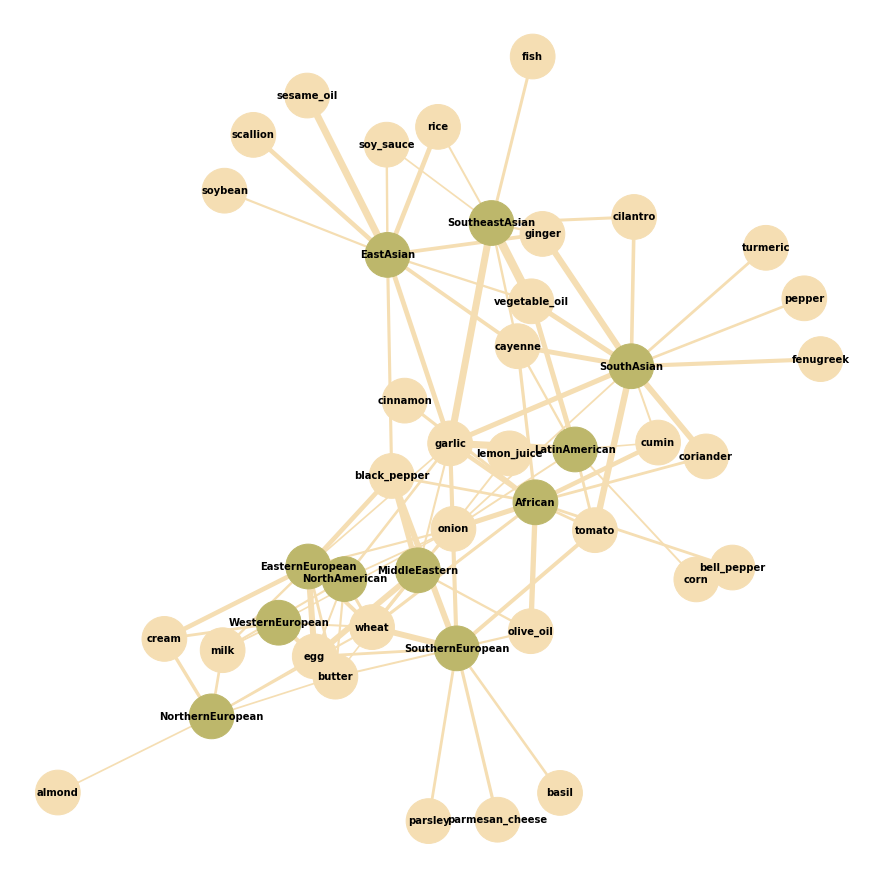

In [623]:
plt.rcParams["figure.figsize"] = (12,12) # set plot size
colors = set_colors(G1)  # set colors
weights = [edata['attr_dict'][15]/10 for f, t, edata in G0.edges(data=True)] # set weights

nx.draw(G1, with_labels=True, node_color=colors, node_size=2000, width=weights,
        font_size=10, font_weight='bold', edge_color="wheat")

Some of the same relationships are even clearer in the second graph than they were in the first, but now we can also see almonds standing out as a uniquely Northern European ingredient.

### Graph the Third Largest 'Island' Subgraph - minimum weight level 37 - 30 nodes

In [571]:
G2=islands[2][1]

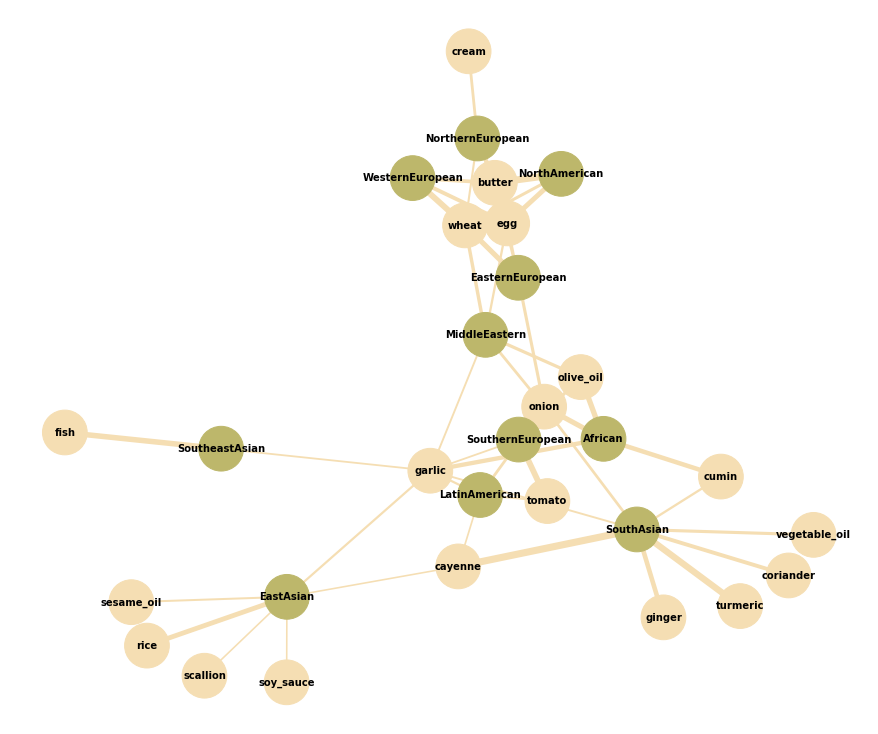

In [694]:
plt.rcParams["figure.figsize"] = (12,10) # set plot size
colors = set_colors(G2)  # set colors
weights = [edata['attr_dict'][15]/10 for f, t, edata in G0.edges(data=True)] # set weights

nx.draw(G2, with_labels=True, node_color=colors, node_size=2000, width=weights,
        font_size=10, font_weight='bold', edge_color="wheat")

The third graph really breaks down each cuisine into it's most common ingredients with each cuisine connected to the graph by no more than 8 ingedients.  This image gives us an idea of the overall difference in flavors among cuisines from different cultures.  

- African -- onion, garlic, olive oil and cumin
- East Asian -- garlic, cyenne, rice, scallions, soy sauce, and sesame oil
- Eastern European -- onion, eggs, butter, and wheat
- Latin American -- onion, garlic, tomato, and cayenne
- Middle Eastern -- onion, garlic, olive oil, eggs, and wheat
- North American -- eggs, butter, and wheat
- Northern European -- eggs, butter, wheat, and cream
- South Asian -- onion, garlic, cumin, cayenne, ginger, coriander, turmeric, 
- Southeast Asian -- garlic and fish
- Southern European -- onion, garlic, olive oil, and tomatoes
- Western European -- eggs, butter, and wheat

We can also see onion and garlic stand out as the two ingredients central to the largest number of cuisines with 6 and 7 connections respectively.  

## Conclusions

As expected we can see very clear similarites and differences among the cuisines of different culures. 

There are more similarites between the cuisines of cultures that share continents in general.  For example, Asian cuisines show more similarities to each other than they do to Northern American and European cuisines.  Northern American and Northern, Western and Eastern European cuisines show many similarities, while Southern European shows more similarity to Latin American, likely due to the cultural heritage of the American vs. 

Latin American settlers.  Southern European, Latin American and Asian Cuisines have an emphasis on more savory and spicy flavors while North American and European cuisines (other than Southern European) have a more buttery, creamy, carb based flavors.  SoutheastAsian really stands out with the inclusion of fish, the only meat-based ingredient. South Asian shows the highest emphsis on spices with all of it's seven top ingredients being spices.

There's a noticable (and notable) lack of sugar anywhere in the list of ingredients which I find particularly surprising considering the prevalence or wheat (probably flour), eggs and butter as top ingredients in many cuisines.  That is definitely an area that should be investigated in future analysis.  